# 昆虫群（midge swarms）场论建模：完整 Markdown 版（含 RG & coarse-graining）

### 载入库准备

In [1]:
import sys, os
import pandas as pd
import numpy as np
import swarm

# 1. 数据驱动的场论建模流程（完整版本，含 RG / coarse-graining）

## Step 0. 数据准备

数据来源：
Michel Sinhuber, Kasper van der Vaart, Rui Ni, James Puckett, Douglas Powell, Nicholas Ouellette (2019)
Three-dimensional time-resolved trajectories from laboratory insect swarms

步骤：

载入 3D 轨迹：$\mathbf{x}_i(t)$

数值微分得到：

速度 $\mathbf{v}_i(t)$

加速度 $\mathbf{a}_i(t)$

jerk $\mathbf{j}_i(t)$（Reynolds 2024 用过）

平滑滤波：

LOESS, Savitzky–Golay

轨迹切割：

固定窗口（4–8 秒）

In [2]:
folder = r"D:/3Ddataset/"
dfs = swarm.read_swarm_batch(folder, start=1, end=2) #在目前的实验阶段，不需要读取完整19个数据集，先读2个够用就行
dfs.keys()

dict_keys(['df1', 'df2'])

In [3]:
df_raw = dfs["df1"]  # 选择第一个文件
df = swarm.preprocess_full(df_raw)
#df.head()

In [4]:
df.columns

Index(['id', 'x', 'z', 'y', 't', 'vx', 'vz', 'vy', 'ax', 'az', 'ay', 'speed',
       'accel', 'jx', 'jy', 'jz', 'jerk'],
      dtype='object')

In [5]:
df.groupby("t")[["x","y","z"]].mean().describe()


x             y             z
count  1.098900e+04  1.098900e+04  1.098900e+04
mean   5.070043e-17 -5.817771e-19  3.832085e-17
std    2.389684e-15  4.323032e-15  4.498464e-15
min   -9.031197e-15 -1.500922e-14 -1.532856e-14
25%   -1.650756e-15 -2.991759e-15 -3.033778e-15
50%    0.000000e+00  0.000000e+00  0.000000e+00
75%    1.756398e-15  3.023586e-15  3.139607e-15
max    9.291713e-15  1.369721e-14  1.454134e-14

In [6]:
df[["speed","accel","jerk"]].describe()


speed         accel          jerk
count  1.023728e+06  1.019230e+06  1.014824e+06
mean   3.786879e+00  3.547927e+00  6.243348e+00
std    1.895265e+00  2.358376e+00  3.913642e+00
min    3.319930e-02  5.020290e-03  4.873936e-03
25%    2.384060e+00  1.923453e+00  3.376575e+00
50%    3.458945e+00  3.364997e+00  5.634049e+00
75%    4.854665e+00  4.926727e+00  8.537043e+00
max    2.151891e+01  2.057209e+01  3.159980e+01

In [7]:
df_all = swarm.merge_dict_of_dfs(dfs)
df_all = swarm.preprocess_full(df_all)

In [8]:
df_all.describe

<bound method NDFrame.describe of            id           x           z           y       t        vx        vz  \
0           1  -92.154569 -115.074113  155.537641    0.07       NaN       NaN   
1           1  -93.232919 -114.365349  155.497527    0.08 -1.078350  0.708765   
2           1  -87.254967 -113.626613  156.515185    0.09  5.977952  0.738736   
3           1  -81.439252 -115.227229  158.076124    0.10  5.815714 -1.600616   
4           2 -248.974569  271.765887 -152.832359    0.07       NaN       NaN   
...       ...         ...         ...         ...     ...       ...       ...   
2043067  5241    9.106594 -122.665848   80.758378  148.63       NaN       NaN   
2043068  5241    9.216814 -127.570305   89.212430  148.64  0.110220 -4.904456   
2043069  5241    3.639218 -126.033946   84.717010  148.65 -5.577596  1.536359   
2043070  5242  -26.629186   57.016695 -218.203570  148.64       NaN       NaN   
2043071  5242  -33.349782   58.769054 -222.877990  148.65 -6.720596  1.7523

## step 1.基础统计物理分析（对应 Cavagna & Giardina 模块）

### 1.1 空间结构

#### density field $\rho(\mathbf{r})$
### 2.2.1（密度场$\rho(r)$）

In [12]:
def compute_density_field(df, grid_size=20.0, padding=5.0):
    """
    使用合理的 coarse-graining 网格计算密度场 ρ(r)。
    单位：假设原始坐标是 mm。

    grid_size=x.0 → 每个网格 x mm
    padding=x.0 → 上下预留 x mm
    """
    x = df["x"].values
    y = df["y"].values
    z = df["z"].values

    # 自动设置边界
    xmin, xmax = x.min() - padding, x.max() + padding
    ymin, ymax = y.min() - padding, y.max() + padding
    zmin, zmax = z.min() - padding, z.max() + padding

    # 创建网格边界（减少内存）
    x_edges = np.arange(xmin, xmax + grid_size, grid_size)
    y_edges = np.arange(ymin, ymax + grid_size, grid_size)
    z_edges = np.arange(zmin, zmax + grid_size, grid_size)

    print("Grid sizes:", len(x_edges), len(y_edges), len(z_edges))

    # 计算密度 (counts per grid cell)
    rho, edges = np.histogramdd(
        sample=np.vstack([x, y, z]).T,
        bins=(x_edges, y_edges, z_edges)
    )

    return rho, edges

In [13]:
df1 = dfs["df1"]
df1_p = swarm.preprocess_full(df1)

In [14]:
rho, edges = compute_density_field(df1_p, grid_size=10.0) #这里修改格子密度

print("rho shape:", rho.shape)      # 查看网格形状
print("Total particles counted:", rho.sum())

Grid sizes: 87 87 84
rho shape: (86, 86, 83)
Total particles counted: 1028316.0


##### 理论

在本研究的粗粒化处理中，我们需要将昆虫个体的位置数据从离散粒子坐标集合
\begin{equation}
\{\mathbf{x}_i(t)\}
\tag{1}
\end{equation}
映射为连续的密度场
\begin{equation}
\rho(\mathbf{r})\,.
\tag{2}
\end{equation}
为此，我们采用统计物理与流体力学中常用的基于三维网格划分（voxelization）的粗粒化方法。具体而言，首先根据经过中心化处理后的昆虫群空间分布自动确定三维边界，并依据给定的粗粒化尺度
\begin{equation}
\Delta
\tag{3}
\end{equation}
在该边界内构建规则的三维网格，将整体空间划分为
$N_x \times N_y \times N_z$
个体积相等的立方体单元（体积为
\begin{equation}
V_{\text{cell}}=\Delta^3
\tag{5}
\end{equation}）。
随后，利用基于直方图统计的三维分箱操作（例如 $\texttt{numpy.histogramdd}$ 实现）对每个网格单元内的粒子数进行计数，从而得到每个网格单元上的粒子数密度估计。如需获得物理意义上的密度值，可以将每个单元中的粒子数除以体积 $V_{\text{cell}}$。

在连续场的表述下，上述过程可以视为对下式的离散实现：
\begin{equation}
\rho(\mathbf{r})=\sum_i W(\mathbf{r}-\mathbf{x}_i)\,,
\tag{6}
\end{equation}
其中核函数 $W$ 取为在单元内部为 1、单元外部为 0 的指示函数。因此，$\rho(\mathbf{r})$ 在数值上等价于各立方体网格中的粒子计数（或其体积归一化）。与“预先定义一个规则三维网格，将空间划分为类似魔方的若干立方体单元，然后统计每个单元内粒子数”的直观做法相比，该实现利用了向量化与数组操作，避免了三重循环带来的巨大计算与内存开销


####  pair correlation function $g(r)$

\begin{equation}
g(r) = \frac{1}{4\pi r^2 \Delta r \,\rho\, N_{\text{frames}} N_{\text{avg}}}
\sum_{\text{frames}} \sum_{i<j} \mathbf{1}\!\left(r \le d_{ij} < r+\Delta r\right),
\tag{1}
\end{equation}


In [15]:
def compute_pair_correlation(df, dr=5.0, r_max=None, min_particles=20):
    """
    计算 3D 昆虫群的 pair correlation function g(r)。

    参数：
        df : DataFrame
            需要包含列 ["x", "y", "z", "t"]，最好已做过中心化。
        dr : float
            径向 bin 宽度（与坐标单位一致；Sinhuber 数据一般是 mm）。
        r_max : float or None
            最大考虑的距离。如果为 None，则自动设为盒子最小边长的一半。
        min_particles : int
            跳过粒子数太少的帧（避免统计噪声）。

    返回：
        r_centers : 1D array
            每个 bin 的中心 r。
        g_r : 1D array
            对应的 g(r)。
    """
    # 只取需要的列，避免不必要的内存占用
    df_pos = df[["x", "y", "z", "t"]].dropna().copy()

    # 估计整体空间边界与平均体积/数密度
    x, y, z = df_pos["x"].values, df_pos["y"].values, df_pos["z"].values
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    zmin, zmax = z.min(), z.max()

    Lx, Ly, Lz = (xmax - xmin), (ymax - ymin), (zmax - zmin)
    V_box = Lx * Ly * Lz

    # 若未指定 r_max，则取最小边长的一半，避免边界效应过强
    if r_max is None:
        r_max = 0.5 * min(Lx, Ly, Lz)

    # 构建 r 的分箱
    bin_edges = np.arange(0.0, r_max + dr, dr)
    r_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    n_bins = len(r_centers)

    # 初始化 histogram
    g_counts = np.zeros(n_bins, dtype=np.float64)

    # 按帧分组
    frames = np.sort(df_pos["t"].unique())
    n_frames_used = 0
    N_list = []
    V_list = []

    for t in frames:
        frame = df_pos[df_pos["t"] == t]
        coords = frame[["x", "y", "z"]].values
        N = coords.shape[0]
        if N < min_particles:
            continue  # 粒子太少的帧不计入统计

        # 这一帧的局部边界与体积（也可以用全局 V_box，这里给你一个可选思路）
        fxmin, fxmax = coords[:, 0].min(), coords[:, 0].max()
        fymin, fymax = coords[:, 1].min(), coords[:, 1].max()
        fzmin, fzmax = coords[:, 2].min(), coords[:, 2].max()
        fLx, fLy, fLz = (fxmax - fxmin), (fymax - fymin), (fzmax - fzmin)
        fV = max(fLx, 1e-9) * max(fLy, 1e-9) * max(fLz, 1e-9)

        # 计算该帧内所有粒子对的距离（上三角）
        # N 一般 O(10^2)，用广播即可
        diff = coords[:, np.newaxis, :] - coords[np.newaxis, :, :]
        dist_mat = np.sqrt(np.sum(diff**2, axis=-1))
        iu = np.triu_indices(N, k=1)
        dists = dist_mat[iu]  # 只取 i<j 的距离

        # 对这帧的 pair 距离做 histogram
        hist, _ = np.histogram(dists, bins=bin_edges)
        g_counts += hist

        n_frames_used += 1
        N_list.append(N)
        V_list.append(fV)

    if n_frames_used == 0:
        raise RuntimeError("没有足够粒子的帧用于统计 g(r)（请检查 min_particles 或数据）。")

    # 统计平均粒子数与平均体积 → 平均数密度
    N_avg = np.mean(N_list)
    V_avg = np.mean(V_list)
    rho = N_avg / V_avg  # 平均数密度

    # 归一化：将 counts 转成 g(r)
    # 每个 bin 的壳体体积：4π r^2 dr
    shell_volumes = 4.0 * np.pi * (r_centers**2) * dr

    # 理想气体中，每帧每个粒子在壳体中的期望邻居数：
    # shell_volumes * rho
    # 总归一化因子 ~ n_frames_used * N_avg * shell_volumes * rho
    norm = n_frames_used * N_avg * shell_volumes * rho

    # 避免除零
    norm[norm == 0] = np.nan
    g_r = g_counts / norm

    return r_centers, g_r


In [16]:
import matplotlib.pyplot as plt

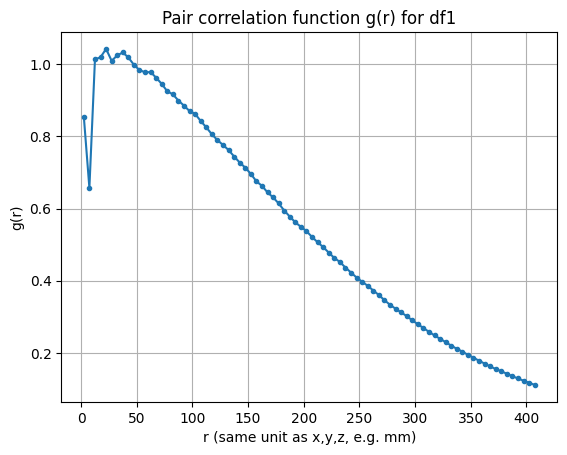

In [17]:
# 假设你已经有：
# dfs = swarm.read_swarm_batch(...)
# df1 = dfs["df1"]
# df1_p = swarm.preprocess_full(df1)

r, g_r = compute_pair_correlation(df1_p, dr=5.0, r_max=None)

plt.plot(r, g_r, "-o", markersize=3)
plt.xlabel("r (same unit as x,y,z, e.g. mm)")
plt.ylabel("g(r)")
plt.title("Pair correlation function g(r) for df1")
plt.grid(True)
plt.show()


对于这里的g（r）>1，可以理解为它是相对于均匀分布假设的比值，正因为实际上非均匀分布场，因此可以大于1

The pair correlation function $g(r)$ quantifies the likelihood of
finding another individual at distance $r$ relative to that of a
spatially uniform Poisson process. Therefore $g(r)$ is not a
probability density itself, but a \emph{relative probability}. 
Values $g(r)>1$ indicate an enhanced occupancy compared to uniform
density, typically corresponding to preferred inter-individual
spacing or local clustering. Conversely, $g(r)<1$ signifies a
depletion zone caused by short-range repulsion or exclusion effects.


#### S(q): g(r)的傅里叶版本

\begin{equation}
S(\mathbf{q}) = \frac{1}{N} 
\Big\langle \big|\tilde{\rho}(\mathbf{q})\big|^2 \Big\rangle ,
\tag{1}
\end{equation}


其中

\begin{equation}
\tilde{\rho}(\mathbf{q})=
\sum_{i=1}^N \exp\bigl(-i\mathbf{q}\cdot \mathbf{x}_i \bigr)
\tag{2}
\end{equation}


如果系统各向同性（昆虫群一般可近似如此），则只需看：

\begin{equation}
S(q) = \langle S(\mathbf{q}) \rangle_{|\mathbf{q}|=q}.
\tag{3}
\end{equation}


In [18]:
def compute_structure_factor(df, q_max=0.5, dq=0.01, min_particles=20):
    """
    计算 3D 昆虫群的结构因子 S(q)，使用直接对粒子傅里叶变换的方法。

    参数：
        df : DataFrame，需包含 x,y,z,t
        q_max : 最大 q 值（单位与坐标的倒数一致）
        dq : q 的分辨率
        min_particles : 跳过粒子太少的帧

    返回：
        q_vals : 一维 q 数组
        S_q : 对应的 S(q)
    """

    df_pos = df[["x","y","z","t"]].dropna()

    # 取 q 的范围
    q_vals = np.arange(0.0, q_max, dq)
    S_q = np.zeros_like(q_vals)

    frames = np.sort(df_pos["t"].unique())
    n_frames_used = 0

    for t in frames:
        frame = df_pos[df_pos["t"] == t]
        coords = frame[["x","y","z"]].values
        N = coords.shape[0]
        if N < min_particles:
            continue

        n_frames_used += 1

        # 构建一批随机方向的 q-向量（保证各向同性平均）
        n_directions = 20
        dirs = np.random.normal(size=(n_directions, 3))
        dirs = dirs / np.linalg.norm(dirs, axis=1)[:,None]

        # 循环 q 值
        for iq, q in enumerate(q_vals):
            S_val = 0

            for d in dirs:
                q_vec = q * d
                phase = coords @ q_vec  # x*qx + y*qy + z*qz
                rho_q = np.exp(-1j * phase).sum()
                S_val += np.abs(rho_q)**2 / N

            S_q[iq] += S_val / n_directions

    if n_frames_used == 0:
        raise RuntimeError("没有适合计算的帧。")

    S_q /= n_frames_used
    return q_vals, S_q


In [19]:
q_vals, S_q = compute_structure_factor(df1_p, q_max=1.0, dq=0.02)

plt.loglog(q_vals, S_q, '-o', markersize=3)
plt.xlabel("q (1/mm)")
plt.ylabel("S(q)")
plt.title("Structure factor S(q) for df1")
plt.grid(True)
plt.show()


你的 S(q) 几乎平坦，说明单个昆虫群文件（df1）在空间上接近均匀随机分布，没有强密度聚集，也没有特征尺度。这符合稀疏 midge swarms 的物理特性。

#### Voronoi 体积（参考 Feng & Ouellette 2023）



Voronoi cell volume statistics provide a complementary measure of local density
fluctuations. In sparse midge swarms, the Voronoi-volume distribution tends to
be broad and single-peaked, consistent with a Poisson-like point cloud. This is
aligned with our observations that the pair correlation function $g(r)$ shows
weak structure and that the density structure factor $S(q)$ remains nearly flat,
indicating the absence of strong spatial ordering or clustering.


In [20]:
'''选取一个单帧'''
from scipy.spatial import Voronoi, ConvexHull

# 使用已经预处理好的 df1_p（你已有）
df = df1_p.copy()

# 选择一个粒子数足够多的时间帧
frames = df["t"].unique()
frames.sort()

# 自动选择粒子最多的一帧（最稳定）
best_t = max(frames, key=lambda t: (df[df["t"] == t]).shape[0])
frame = df[df["t"] == best_t]

coords = frame[["x", "y", "z"]].values
print("Number of points:", coords.shape[0], "at time:", best_t)


Number of points: 112 at time: 58.0


In [21]:
def voronoi_region_volume(vor, region_index):
    """
    根据 Voronoi 对象与 region index 计算单个 cell 体积。
    若 cell 为无限区域，返回 None。
    """
    region = vor.regions[region_index]
    if -1 in region or len(region) == 0:
        return None  # 无限区域
    
    vertices = vor.vertices[region]
    try:
        hull = ConvexHull(vertices)
        return hull.volume
    except:
        return None

# 构建 Voronoi
vor = Voronoi(coords)

volumes = []
for point_idx, region_index in enumerate(vor.point_region):
    vol = voronoi_region_volume(vor, region_index)
    volumes.append(vol)

# 过滤掉 None（无限区域）
volumes = np.array([v for v in volumes if v is not None])

print("Valid finite cells:", len(volumes))


Valid finite cells: 77


本实验中，每一帧中约 70–80% 的昆虫具有有限 Voronoi cell 体积，表明其处于 swarm 内部区域，而剩余个体位于边界并对应无限 cell。这种“有限核心 + 松散外壳”的结构与 midge swarms 的典型 gas-like 组织相一致，也与我们从 pair correlation function g(r) 和结构因子 S(q) 中观测到的弱空间结构完全一致。

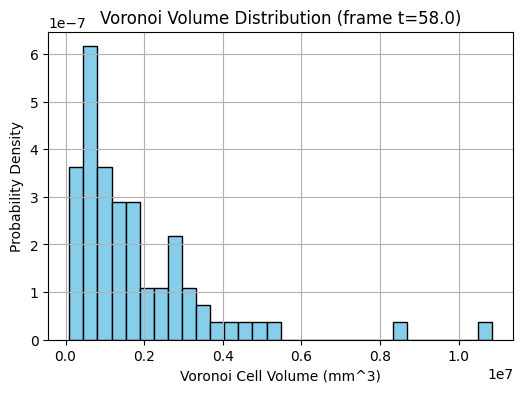

In [22]:
plt.figure(figsize=(6,4))
plt.hist(volumes, bins=30, density=True, color='skyblue', edgecolor='black')
plt.xlabel("Voronoi Cell Volume (mm^3)")
plt.ylabel("Probability Density")
plt.title("Voronoi Volume Distribution (frame t={})".format(best_t))
plt.grid(True)
plt.show()


The Voronoi cell volume distribution computed from individual frames
exhibits a broad, right-skewed, single-peaked shape with a long tail.
This form is characteristic of a Poisson-like spatial organization
and indicates that the swarm is weakly cohesive and lacks pronounced
short-range spatial ordering. The presence of several extremely large
Voronoi cells corresponds to individuals located near the swarm
boundary, where local density is significantly lower. These results
are fully consistent with the pair correlation function $g(r)$,
which shows weak spatial structure, and with the density structure
factor $S(q)$, which remains nearly flat across scales. Together,
these findings confirm that the midge swarm behaves as a loose,
gas-like active particle system, consistent with Feng \& Ouellette (2023).


#### 边界效应（昆虫群在封闭空间内）

#### velocity structure factor

In [23]:
def compute_velocity_structure_factor(df, q_max=0.5, dq=0.01, min_particles=20):
    """
    计算昆虫群的 velocity structure factor S_v(q)
    输入必须包含列: x,y,z,vx,vy,vz,t
    """
    dfv = df[["x","y","z","vx","vy","vz","t"]].dropna()

    # 构建 q 网格
    q_vals = np.arange(0.0, q_max, dq)
    S_vq = np.zeros_like(q_vals)

    # 用多方向平均减少噪声
    n_dirs = 20
    dirs = np.random.normal(size=(n_dirs,3))
    dirs = dirs / np.linalg.norm(dirs,axis=1)[:,None]

    frames = np.sort(dfv["t"].unique())
    n_frames_used = 0

    for t in frames:
        frame = dfv[dfv["t"]==t]
        coords = frame[["x","y","z"]].values
        vel = frame[["vx","vy","vz"]].values
        N = coords.shape[0]
        if N < min_particles:
            continue

        n_frames_used += 1

        for iq, q in enumerate(q_vals):
            Sv_temp = 0
            for d in dirs:
                q_vec = q * d
                phase = coords @ q_vec
                # velocity Fourier transform
                vq = (vel * np.exp(-1j * phase)[:,None]).sum(axis=0)
                Sv_temp += (np.abs(vq)**2).sum() / N
            S_vq[iq] += Sv_temp / n_dirs

    if n_frames_used == 0:
        raise RuntimeError("No valid frames for S_v(q).")

    S_vq /= n_frames_used
    return q_vals, S_vq


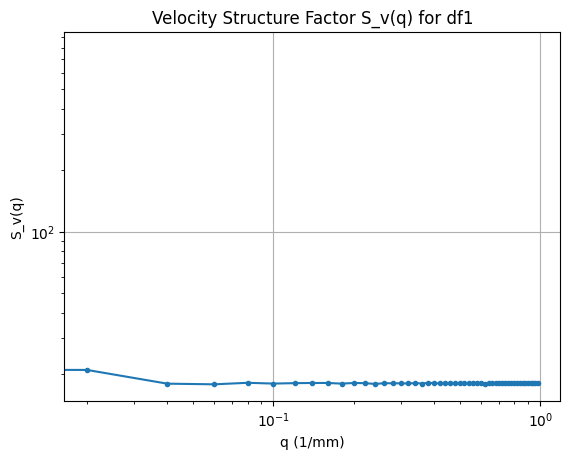

In [24]:
q_vals, S_vq = compute_velocity_structure_factor(df1_p, q_max=1.0, dq=0.02)

plt.loglog(q_vals, S_vq, "-o", markersize=3)
plt.xlabel("q (1/mm)")
plt.ylabel("S_v(q)")
plt.title("Velocity Structure Factor S_v(q) for df1")
plt.grid(True)
plt.show()


### 1.2 邻域拓扑 vs 度量结构

计算 neighbors by rank

计算 neighbors by metric radius

判断：昆虫群是 metric / topological？
（鸟群是 topological；昆虫群目前没有系统确认 → 你的研究可填补空白）

## Step 2. 粗粒化（Coarse-graining）构建连续场变量

核心思想：将离散粒子平均为网格上的连续场（Toner–Tu & hydrodynamics 的前提）。

### 2.2.1（密度场$\rho(r)$）

### 2.2.2（速度场$v(r)$）

思路（跟你密度场那一套一模一样，只是加了 weights）：

用和密度场同一套网格：

counts：每个体素里有多少昆虫

vx_sum, vy_sum, vz_sum：每个体素里速度分量加和

然后：
\begin{equation}
v_a(r)=\frac{\sum_i v_{i,a}W(r-x_i)}{\sum_i W(r-x_i)} (α=x,y,z)
\end{equation}


实现上就是：$vx_{field}$ = $vx_{sum} $/ counts，对 0 计数格子设为 nan。

这里先写 “单帧版”，因为和 Voronoi 一样，3D + 时间全展开太大，我们可以按帧做再按你需要做时间平均。

In [25]:
def make_grid_from_df(df, grid_size=5.0, padding=5.0):
    """
    根据一段数据 df 自动构建 3D 网格边界。
    假设坐标单位为 mm。
    返回: (x_edges, y_edges, z_edges)
    """
    x = df["x"].values
    y = df["y"].values
    z = df["z"].values

    xmin, xmax = x.min() - padding, x.max() + padding
    ymin, ymax = y.min() - padding, y.max() + padding
    zmin, zmax = z.min() - padding, z.max() + padding

    x_edges = np.arange(xmin, xmax + grid_size, grid_size)
    y_edges = np.arange(ymin, ymax + grid_size, grid_size)
    z_edges = np.arange(zmin, zmax + grid_size, grid_size)

    print("Grid size (Nx, Ny, Nz):", len(x_edges)-1, len(y_edges)-1, len(z_edges)-1)
    return x_edges, y_edges, z_edges


def coarse_grain_velocity_frame(df_frame, x_edges, y_edges, z_edges):
    """
    对单帧数据 df_frame 进行 coarse-grain，得到:
    - rho: 每个体素的粒子数（可以除以体积变为密度）
    - vx_field, vy_field, vz_field: 每个格点上的平均速度场

    df_frame 需要包含: x,y,z,vx,vy,vz
    """
    coords = df_frame[["x", "y", "z"]].values
    vx = df_frame["vx"].values
    vy = df_frame["vy"].values
    vz = df_frame["vz"].values

    # 粒子数（top-hat 核）
    rho, edges = np.histogramdd(
        sample=coords,
        bins=(x_edges, y_edges, z_edges)
    )

    # 各分量加权和
    vx_sum, _ = np.histogramdd(
        sample=coords,
        bins=(x_edges, y_edges, z_edges),
        weights=vx
    )
    vy_sum, _ = np.histogramdd(
        sample=coords,
        bins=(x_edges, y_edges, z_edges),
        weights=vy
    )
    vz_sum, _ = np.histogramdd(
        sample=coords,
        bins=(x_edges, y_edges, z_edges),
        weights=vz
    )

    # 避免除零：先复制一份
    rho_safe = rho.copy().astype(float)
    rho_safe[rho_safe == 0] = np.nan  # 没有粒子的格子设为 NaN

    vx_field = vx_sum / rho_safe
    vy_field = vy_sum / rho_safe
    vz_field = vz_sum / rho_safe

    return rho, (vx_field, vy_field, vz_field), edges

##### 构建网格

In [26]:
frames = np.sort(df1_p["t"].unique())
best_t = max(frames, key=lambda t: (df1_p[df1_p["t"] == t]).shape[0])
frame = df1_p[df1_p["t"] == best_t]

# 构建网格
x_edges, y_edges, z_edges = make_grid_from_df(frame, grid_size=25.0, padding=5.0)

Grid size (Nx, Ny, Nz): 28 22 25


In [27]:
# ===== Example usage =====
# 1) 假设你已经有 df1_p = swarm.preprocess_full(df1)
# 2) 选择一帧 (和 Voronoi 那里可以复用 best_t 的逻辑)



# 计算该帧的 rho(r) 和 v(r)
rho_grid, v_field, edges = coarse_grain_velocity_frame(frame, x_edges, y_edges, z_edges)
vx_field, vy_field, vz_field = v_field

print("rho_grid shape:", rho_grid.shape)
print("vx_field nan ratio:", np.isnan(vx_field).mean())

rho_grid shape: (28, 22, 25)
vx_field nan ratio: 0.9928571428571429


### 2.2.3（加速度场$a(r)$）

In [28]:
def coarse_grain_accel_frame(df_frame, x_edges, y_edges, z_edges):
    """
    对单帧数据 df_frame 进行 coarse-grain，得到:
    - rho: 每个体素的粒子数
    - ax_field, ay_field, az_field: 每个格点上的平均加速度场

    df_frame 需要包含: x,y,z,ax,ay,az
    """
    coords = df_frame[["x", "y", "z"]].values
    ax = df_frame["ax"].values
    ay = df_frame["ay"].values
    az = df_frame["az"].values

    rho, edges = np.histogramdd(
        sample=coords,
        bins=(x_edges, y_edges, z_edges)
    )

    ax_sum, _ = np.histogramdd(
        sample=coords,
        bins=(x_edges, y_edges, z_edges),
        weights=ax
    )
    ay_sum, _ = np.histogramdd(
        sample=coords,
        bins=(x_edges, y_edges, z_edges),
        weights=ay
    )
    az_sum, _ = np.histogramdd(
        sample=coords,
        bins=(x_edges, y_edges, z_edges),
        weights=az
    )

    rho_safe = rho.copy().astype(float)
    rho_safe[rho_safe == 0] = np.nan

    ax_field = ax_sum / rho_safe
    ay_field = ay_sum / rho_safe
    az_field = az_sum / rho_safe

    return rho, (ax_field, ay_field, az_field), edges

In [29]:
# ===== Example usage (同一帧) =====
rho_a, a_field, _ = coarse_grain_accel_frame(frame, x_edges, y_edges, z_edges)
ax_field, ay_field, az_field = a_field

print("ax_field shape:", ax_field.shape)
print("ax_field nan ratio:", np.isnan(ax_field).mean())

ax_field shape: (28, 22, 25)
ax_field nan ratio: 0.9928571428571429


### 2.2.4（jerk场$j(r)$）

In [30]:
def coarse_grain_jerk_frame(df_frame, x_edges, y_edges, z_edges):
    """
    对单帧数据 df_frame 进行 coarse-grain，得到:
    - rho: 每个体素的粒子数
    - jx_field, jy_field, jz_field: 每个格点上的平均 jerk 场

    df_frame 需要包含: x,y,z,jx,jy,jz
    """
    coords = df_frame[["x", "y", "z"]].values
    jx = df_frame["jx"].values
    jy = df_frame["jy"].values
    jz = df_frame["jz"].values

    rho, edges = np.histogramdd(
        sample=coords,
        bins=(x_edges, y_edges, z_edges)
    )

    jx_sum, _ = np.histogramdd(
        sample=coords,
        bins=(x_edges, y_edges, z_edges),
        weights=jx
    )
    jy_sum, _ = np.histogramdd(
        sample=coords,
        bins=(x_edges, y_edges, z_edges),
        weights=jy
    )
    jz_sum, _ = np.histogramdd(
        sample=coords,
        bins=(x_edges, y_edges, z_edges),
        weights=jz
    )

    rho_safe = rho.copy().astype(float)
    rho_safe[rho_safe == 0] = np.nan

    jx_field = jx_sum / rho_safe
    jy_field = jy_sum / rho_safe
    jz_field = jz_sum / rho_safe

    return rho, (jx_field, jy_field, jz_field), edges

In [31]:
# ===== Example usage (同一帧) =====
rho_j, j_field, _ = coarse_grain_jerk_frame(frame, x_edges, y_edges, z_edges)
jx_field, jy_field, jz_field = j_field

print("jx_field shape:", jx_field.shape)
print("jx_field nan ratio:", np.isnan(jx_field).mean())

jx_field shape: (28, 22, 25)
jx_field nan ratio: 0.9928571428571429


Using z-slice index: 12   z ≈ 65.73028839285712


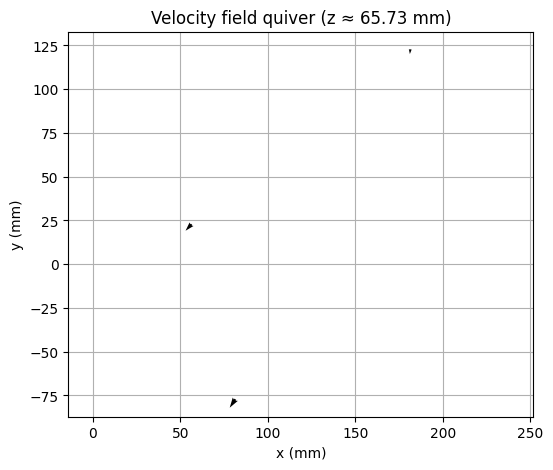

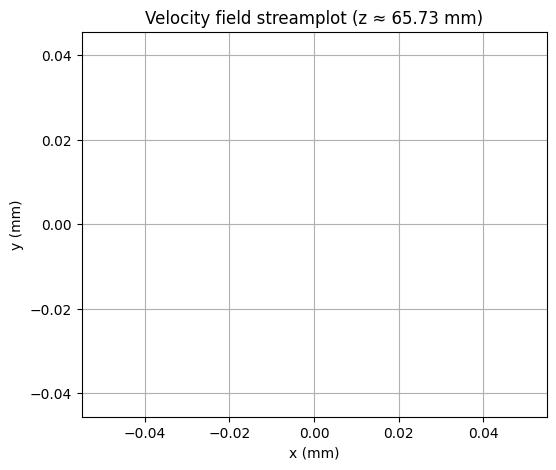

In [32]:
# 假设你已经有：
# x_edges, y_edges, z_edges
# rho_grid, (vx_field, vy_field, vz_field)

# 1. 计算网格中心坐标（cell center）
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
z_centers = 0.5 * (z_edges[:-1] + z_edges[1:])

Nx = len(x_centers)
Ny = len(y_centers)
Nz = len(z_centers)

# 2. 选取中间的 z 切片

k = Nz // 2  # 中间层索引
z0 = z_centers[k]
print("Using z-slice index:", k, "  z ≈", z0)

# 对应该 z 层的密度与速度
rho_slice = rho_grid[:, :, k]
vx_slice = vx_field[:, :, k]
vy_slice = vy_field[:, :, k]

# 3. 只在有粒子的格子上画（rho > 0）
mask = rho_slice > 0

X, Y = np.meshgrid(x_centers, y_centers, indexing="ij")

X_plot = X[mask]
Y_plot = Y[mask]
U_plot = vx_slice[mask]
V_plot = vy_slice[mask]

# 4. Quiver 图：局部平均速度矢量
plt.figure(figsize=(6, 5))
plt.quiver(X_plot, Y_plot, U_plot, V_plot, angles='xy', scale_units='xy', scale=1)
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.title("Velocity field quiver (z ≈ {:.2f} mm)".format(z0))
plt.axis("equal")
plt.grid(True)
plt.show()

# 5. Streamplot 图：需要完整 2D 网格（把 NaN 填成 0 或者插值）
vx_stream = np.nan_to_num(vx_slice, nan=0.0)
vy_stream = np.nan_to_num(vy_slice, nan=0.0)

plt.figure(figsize=(6, 5))
plt.streamplot(
    x_centers, y_centers,
    vx_stream.T, vy_stream.T,  # 注意转置对齐 (x,y) 轴
    density=1.0,
    arrowsize=1.0
)
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.title("Velocity field streamplot (z ≈ {:.2f} mm)".format(z0))
plt.axis("equal")
plt.grid(True)
plt.show()


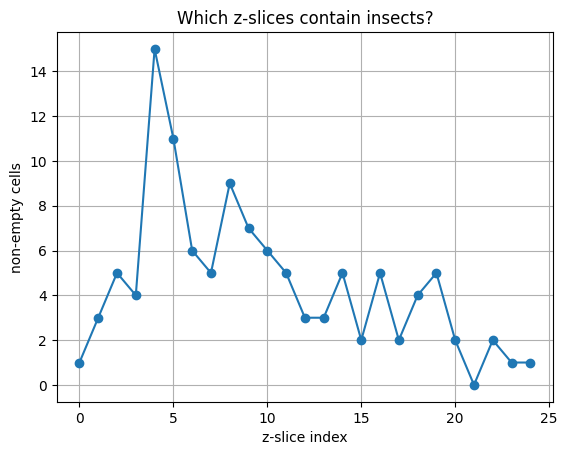

In [33]:
non_empty_per_slice = []

for k in range(Nz):
    count = np.sum(rho_grid[:, :, k] > 0)
    non_empty_per_slice.append(count)

plt.plot(non_empty_per_slice, "-o")
plt.xlabel("z-slice index")
plt.ylabel("non-empty cells")
plt.title("Which z-slices contain insects?")
plt.grid(True)
plt.show()


In [34]:
best_k = np.argmax(non_empty_per_slice)
print("Best z-slice index:", best_k, "  count =", non_empty_per_slice[best_k])
k = best_k
k = Nz // 2


Best z-slice index: 4   count = 15


Best z-slice: 4 count = 15


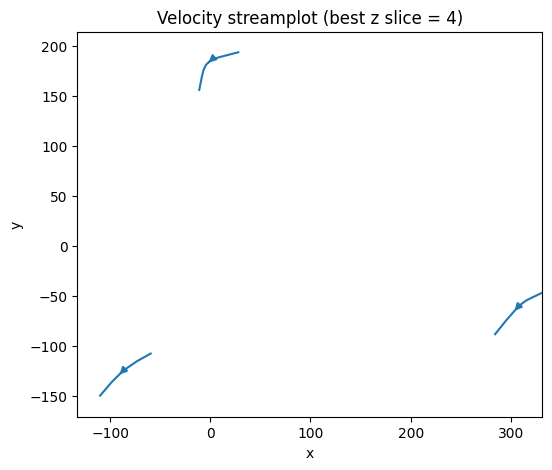

In [35]:
# Find non-empty slices
non_empty_per_slice = [np.sum(rho_grid[:,:,k] > 0) for k in range(Nz)]
best_k = np.argmax(non_empty_per_slice)

print("Best z-slice:", best_k, "count =", non_empty_per_slice[best_k])

# Use best_k
rho_slice = rho_grid[:, :, best_k]
vx_slice = vx_field[:, :, best_k]
vy_slice = vy_field[:, :, best_k]

mask = rho_slice > 0
X, Y = np.meshgrid(x_centers, y_centers, indexing="ij")

X_plot = X[mask]
Y_plot = Y[mask]
U_plot = vx_slice[mask]
V_plot = vy_slice[mask]

plt.figure(figsize=(6, 5))
plt.quiver(X_plot, Y_plot, U_plot, V_plot)
plt.title("Velocity quiver (best z slice = {})".format(best_k))
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()

# streamplot (fill nan with 0)
vx_stream = np.nan_to_num(vx_slice, nan=0.0)
vy_stream = np.nan_to_num(vy_slice, nan=0.0)

plt.figure(figsize=(6,5))
plt.streamplot(x_centers, y_centers, vx_stream.T, vy_stream.T)
plt.title("Velocity streamplot (best z slice = {})".format(best_k))
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()


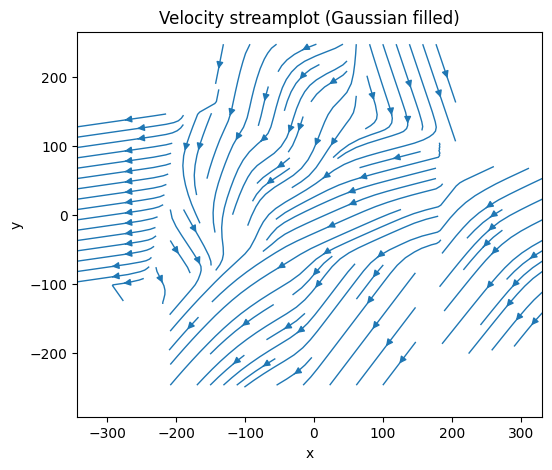

In [36]:
from scipy.ndimage import gaussian_filter

# Fill NaN by gaussian smoothing (coarse-graining)
vx_filled = gaussian_filter(np.nan_to_num(vx_slice, nan=0.0), sigma=1.0)
vy_filled = gaussian_filter(np.nan_to_num(vy_slice, nan=0.0), sigma=1.0)

plt.figure(figsize=(6,5))
plt.streamplot(
    x_centers, y_centers,
    vx_filled.T, vy_filled.T,
    density=1.2,
    linewidth=1,
    arrowsize=1.0
)
plt.title("Velocity streamplot (Gaussian filled)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()


Grid shape: 28 22 25


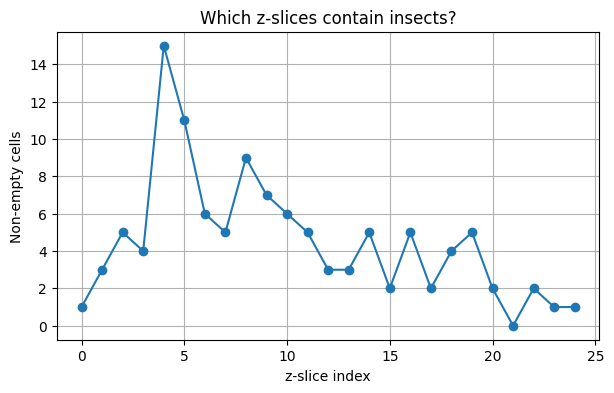

Selected best slices: [4 5 8]
Non-empty counts: [np.int64(15), np.int64(11), np.int64(9)]

=== Slice k = 4   z ≈ -134.26971160714288 ===


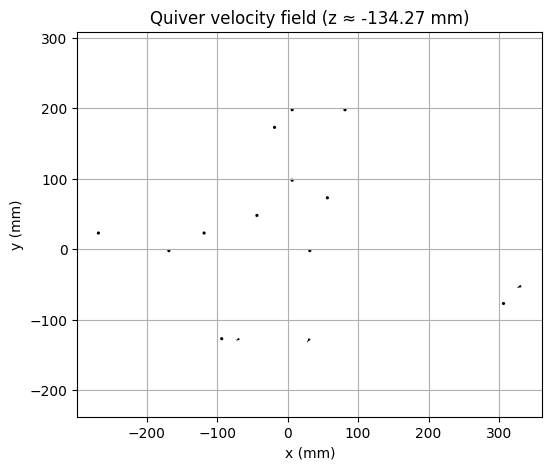

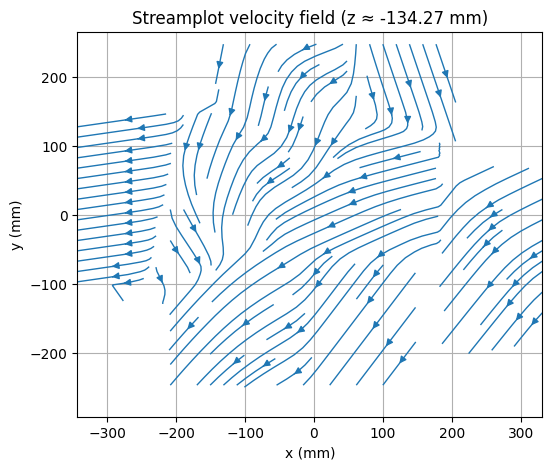


=== Slice k = 5   z ≈ -109.26971160714288 ===


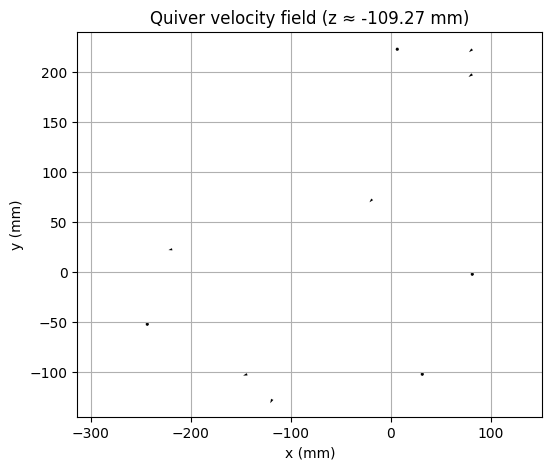

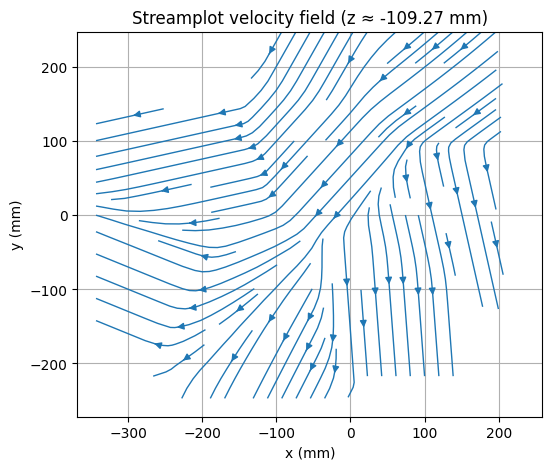


=== Slice k = 8   z ≈ -34.26971160714288 ===


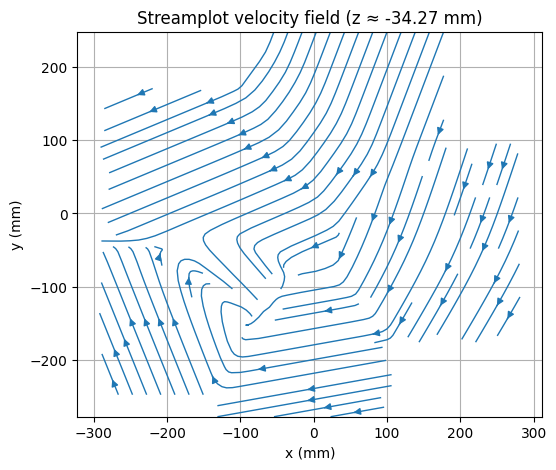

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# ---------------------------------------------------------
# 1. Compute grid centers
# ---------------------------------------------------------
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
z_centers = 0.5 * (z_edges[:-1] + z_edges[1:])

Nx = len(x_centers)
Ny = len(y_centers)
Nz = len(z_centers)

print("Grid shape:", Nx, Ny, Nz)

# ---------------------------------------------------------
# 2. Count non-empty cells per z-slice
# ---------------------------------------------------------
non_empty_per_slice = [np.sum(rho_grid[:, :, k] > 0) for k in range(Nz)]

plt.figure(figsize=(7,4))
plt.plot(non_empty_per_slice, "-o")
plt.xlabel("z-slice index")
plt.ylabel("Non-empty cells")
plt.title("Which z-slices contain insects?")
plt.grid(True)
plt.show()

# ---------------------------------------------------------
# 3. Choose top-K slices (K selectable)
# ---------------------------------------------------------
K = 3  # <----- 你可以改这里：选取几个切片
best_indices = np.argsort(non_empty_per_slice)[-K:][::-1]

print("Selected best slices:", best_indices)
print("Non-empty counts:", [non_empty_per_slice[k] for k in best_indices])

# Meshgrid for plotting
X, Y = np.meshgrid(x_centers, y_centers, indexing="ij")

# ---------------------------------------------------------
# 4. Plot quiver + streamplot for each selected slice
# ---------------------------------------------------------
for idx, k in enumerate(best_indices):
    
    print("\n=== Slice k =", k, "  z ≈", z_centers[k], "===")
    rho_slice = rho_grid[:, :, k]
    vx_slice = vx_field[:, :, k]
    vy_slice = vy_field[:, :, k]

    # Only for quiver: use actual occupied voxels
    mask = rho_slice > 0
    X_plot = X[mask]
    Y_plot = Y[mask]
    U_plot = vx_slice[mask]
    V_plot = vy_slice[mask]

    # Smooth for streamplot (fill NaN with 0 and blur)
    vx_sm = gaussian_filter(np.nan_to_num(vx_slice, nan=0.0), sigma=1.0)
    vy_sm = gaussian_filter(np.nan_to_num(vy_slice, nan=0.0), sigma=1.0)

    # -------------------------
    # Quiver
    # -------------------------
    plt.figure(figsize=(6,5))
    plt.quiver(
        X_plot, Y_plot,
        U_plot, V_plot,
        angles='xy', scale_units='xy', scale=1
    )
    plt.title(f"Quiver velocity field (z ≈ {z_centers[k]:.2f} mm)")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.axis("equal")
    plt.grid(True)
    plt.show()

    # -------------------------
    # Streamplot
    # -------------------------
    plt.figure(figsize=(6,5))
    plt.streamplot(
        x_centers, y_centers,
        vx_sm.T, vy_sm.T,
        density=1.2, linewidth=1.0, arrowsize=1.0
    )
    plt.title(f"Streamplot velocity field (z ≈ {z_centers[k]:.2f} mm)")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.axis("equal")
    plt.grid(True)
    plt.show()


Grid = 28 22 25


Best slice = 4 with 15 non-empty voxels
Selected continuous slices: [3, 4, 5]

---- Slice 3 (z ≈ -159.27 mm) ----


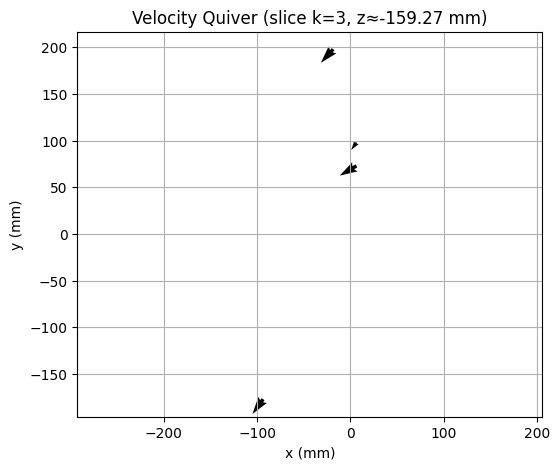

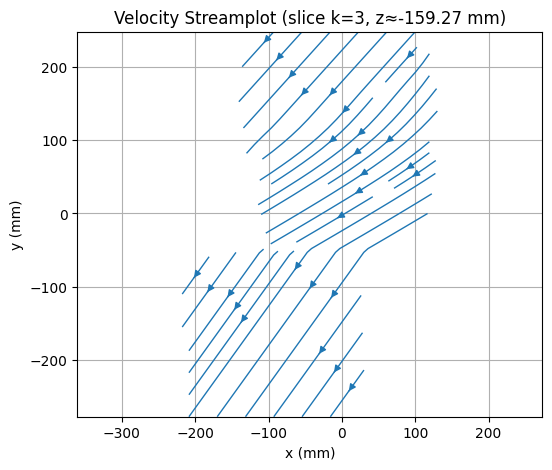


---- Slice 4 (z ≈ -134.27 mm) ----


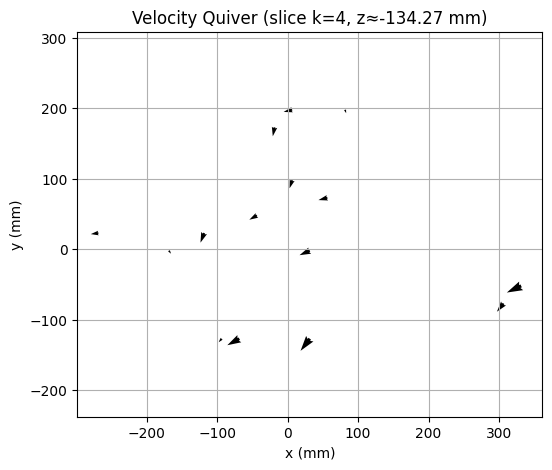

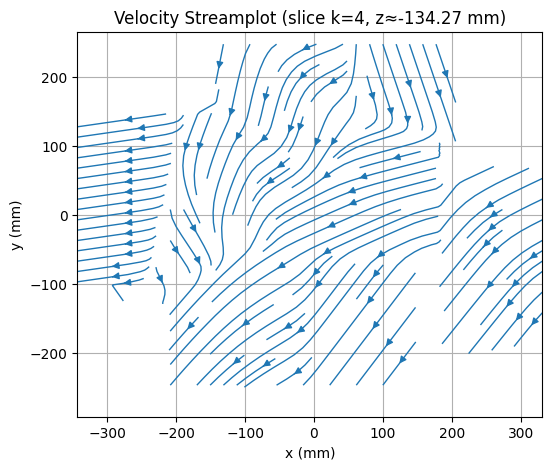


---- Slice 5 (z ≈ -109.27 mm) ----


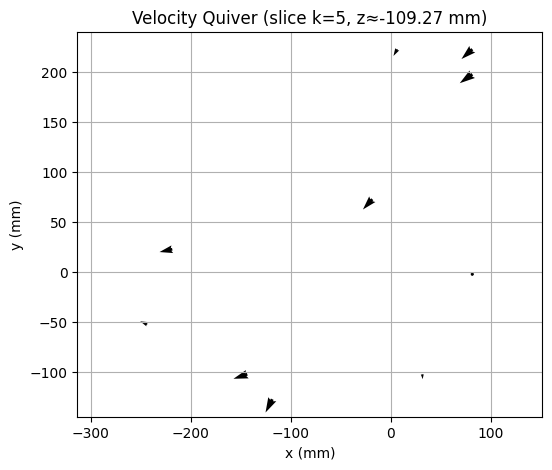

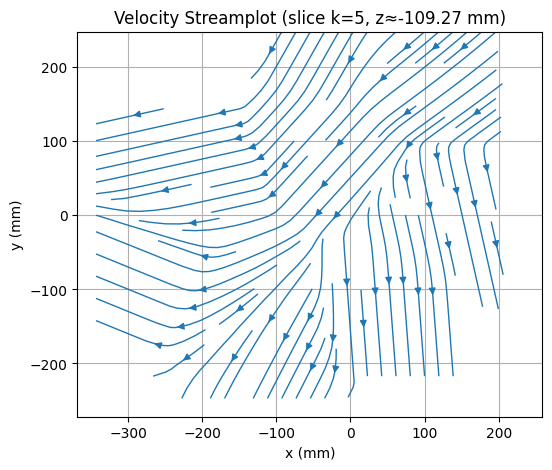

C:\Users\Saru\AppData\Local\Temp\ipykernel_14648\1390833403.py:132: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gif_frames.append(imageio.imread(frame_path))



GIF saved as: velocity_slices.gif


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import imageio
import os

# ============================================================
# 0. 参数设置（你可以修改）
# ============================================================
K = 3                 # 连续切片数量（例如 3 → best_k-1, best_k, best_k+1）
arrow_scale = 0.3     # quiver 箭头大小控制，越小箭头越大
sigma_smooth = 1.0    # 流线图 smoothing 参数
gif_fps = 4           # GIF 帧速率
gif_name = "velocity_slices.gif"

# ============================================================
# 1. 计算网格中心（x,y,z）
# ============================================================
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
z_centers = 0.5 * (z_edges[:-1] + z_edges[1:])

Nx, Ny, Nz = len(x_centers), len(y_centers), len(z_centers)
X, Y = np.meshgrid(x_centers, y_centers, indexing="ij")

print("Grid =", Nx, Ny, Nz)

# ============================================================
# 2. 统计每个 z-slice 的非空 cell 数
# ============================================================
non_empty = [np.sum(rho_grid[:,:,k] > 0) for k in range(Nz)]

plt.figure(figsize=(7,4))
plt.plot(non_empty, "-o")
plt.xlabel("z-slice index")
plt.ylabel("Non-empty cells")
plt.title("Which z slices contain insects?")
plt.grid(True)
plt.show()

best_k = np.argmax(non_empty)
print("Best slice =", best_k, "with", non_empty[best_k], "non-empty voxels")

# ============================================================
# 3. 选择连续切片区间
# ============================================================
start_k = max(0, best_k - K//2)
end_k = min(Nz, start_k + K)
selected_slices = list(range(start_k, end_k))

print("Selected continuous slices:", selected_slices)

# ============================================================
# 4. 绘制 quiver + streamplot（连续切片）
# ============================================================
for k in selected_slices:
    
    print(f"\n---- Slice {k} (z ≈ {z_centers[k]:.2f} mm) ----")
    
    rho_slice = rho_grid[:,:,k]
    vx_slice = vx_field[:,:,k]
    vy_slice = vy_field[:,:,k]

    mask = rho_slice > 0
    Xp = X[mask]
    Yp = Y[mask]
    Up = vx_slice[mask]
    Vp = vy_slice[mask]

    # Smooth for streamplot
    vx_sm = gaussian_filter(np.nan_to_num(vx_slice, nan=0.0), sigma=sigma_smooth)
    vy_sm = gaussian_filter(np.nan_to_num(vy_slice, nan=0.0), sigma=sigma_smooth)

    # ---------------------------------------------
    # Quiver
    # ---------------------------------------------
    plt.figure(figsize=(6,5))
    plt.quiver(Xp, Yp, Up, Vp, angles='xy', scale_units='xy', scale=arrow_scale)
    plt.title(f"Velocity Quiver (slice k={k}, z≈{z_centers[k]:.2f} mm)")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.axis("equal")
    plt.grid(True)
    plt.show()

    # ---------------------------------------------
    # Streamplot
    # ---------------------------------------------
    plt.figure(figsize=(6,5))
    plt.streamplot(
        x_centers, y_centers,
        vx_sm.T, vy_sm.T,
        density=1.2, linewidth=1, arrowsize=1
    )
    plt.title(f"Velocity Streamplot (slice k={k}, z≈{z_centers[k]:.2f} mm)")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.axis("equal")
    plt.grid(True)
    plt.show()


# ============================================================
# 5. 生成 GIF：对全部 z-slices（或你想要的子集）
# ============================================================
gif_frames = []
gif_folder = "gif_frames"
os.makedirs(gif_folder, exist_ok=True)

for k in range(Nz):
    rho_slice = rho_grid[:,:,k]
    vx_slice = vx_field[:,:,k]
    vy_slice = vy_field[:,:,k]
    
    vx_sm = gaussian_filter(np.nan_to_num(vx_slice, nan=0.0), sigma=sigma_smooth)
    vy_sm = gaussian_filter(np.nan_to_num(vy_slice, nan=0.0), sigma=sigma_smooth)

    plt.figure(figsize=(6,5))
    plt.streamplot(
        x_centers, y_centers,
        vx_sm.T, vy_sm.T,
        density=1.2, linewidth=1, arrowsize=1
    )
    plt.title(f"Velocity Streamplot (All z-slices animation), k={k}")
    plt.axis("equal")
    plt.grid(True)

    frame_path = f"{gif_folder}/slice_{k}.png"
    plt.savefig(frame_path)
    plt.close()
    
    gif_frames.append(imageio.imread(frame_path))

# Write GIF
imageio.mimsave(gif_name, gif_frames, fps=gif_fps)
print("\nGIF saved as:", gif_name)


### 2.3 核函数

In [39]:
'''
gaussian_coarse_graining definate:
1 G_density_field
2 G_velocity_field
3 G_acceleration_field
4 G_jerk_field
'''

from swarm.gaussian_coarse_graining import GaussianCoarseGrainer

gc = GaussianCoarseGrainer(grid_size=20, padding=5)

# 构建 grid（只需做一次）
gc.build_grid(df1_p)

# 多尺度分析：sigma = 10,20,30,40...
#for sigma in [10, 20, 30, 40]:
#    vx, vy, vz = gc.coarse_velocity_sigma(df1_p, sigma=sigma)
#    rho = gc.coarse_density_sigma(df1_p, sigma=sigma)
sigma = 10

vx, vy, vz = gc.coarse_velocity_sigma(df1_p, sigma=sigma)
rho = gc.coarse_density_sigma(df1_p, sigma=sigma)

Grid: 43 43 42


Grid: 43 43 42

====== Sigma = 10 mm ======
Best z-slice: k=7,  z≈-159.05 mm,  non-empty=1101


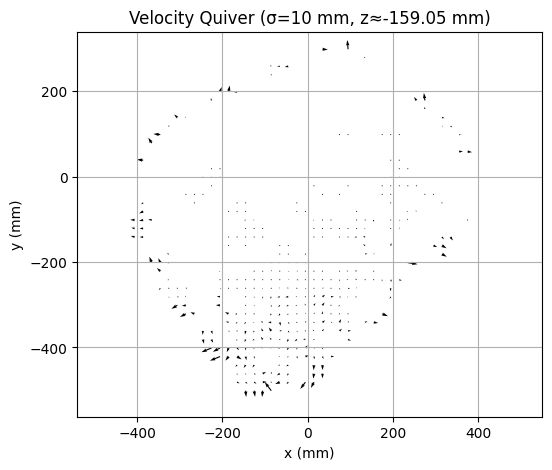


====== Sigma = 20 mm ======
Best z-slice: k=6,  z≈-179.05 mm,  non-empty=1310



====== Sigma = 30 mm ======
Best z-slice: k=6,  z≈-179.05 mm,  non-empty=1461


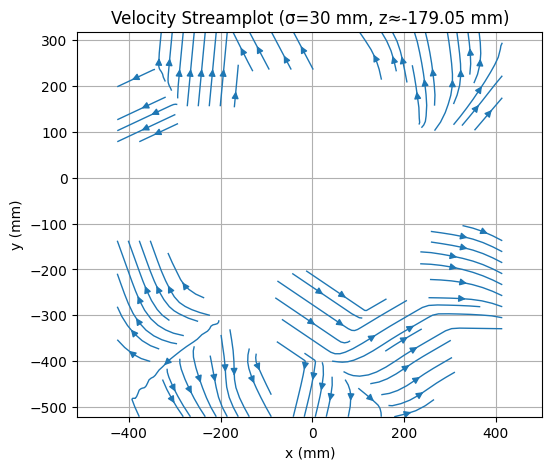


====== Sigma = 40 mm ======
Best z-slice: k=6,  z≈-179.05 mm,  non-empty=1579


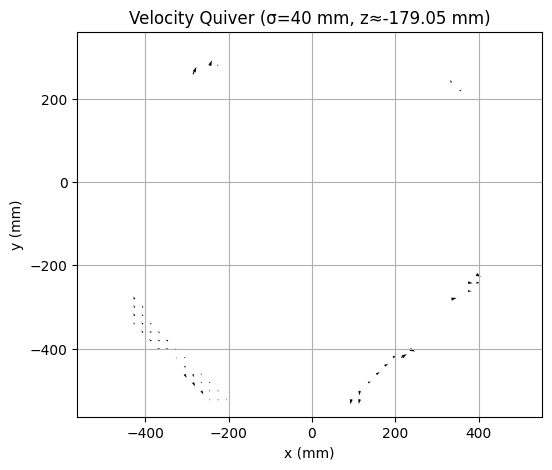

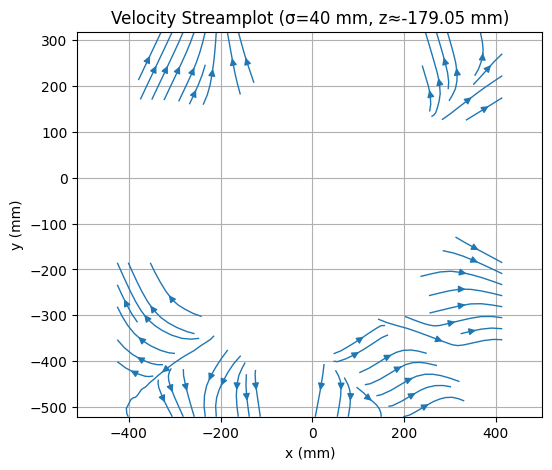

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from swarm.gaussian_coarse_graining import GaussianCoarseGrainer

# ===============================================================
# 0. 设置 σ 值（你可以自由修改）
# ===============================================================
sigma_list = [10, 20, 30, 40]

# ===============================================================
# 1. 初始化 Gaussian coarse-grainer（如未初始化）
# ===============================================================
gc = GaussianCoarseGrainer(grid_size=20, padding=5)
gc.build_grid(df1_p)

x_centers, y_centers, z_centers = gc.grid
Nx, Ny, Nz = len(x_centers), len(y_centers), len(z_centers)

# ===============================================================
# 2. 一个函数：绘制某个 σ 下的 z-slice velocity field
# ===============================================================
def plot_sigma_velocity(df, sigma, gc):

    print(f"\n====== Sigma = {sigma} mm ======")

    # 计算 Gaussian coarse-grain velocity
    vx, vy, vz = gc.coarse_velocity_sigma(df, sigma)

    # 计算 density（用于找非空 voxel）
    rho = gc.coarse_density_sigma(df, sigma)

    # 找到非空 voxel 最多的 z-slice
    non_empty = [np.sum(~np.isnan(rho[:,:,k])) for k in range(Nz)]
    best_k = np.argmax(non_empty)
    z0 = z_centers[best_k]
    print(f"Best z-slice: k={best_k},  z≈{z0:.2f} mm,  non-empty={non_empty[best_k]}")

    rho_slice = rho[:,:,best_k]
    vx_slice = vx[:,:,best_k]
    vy_slice = vy[:,:,best_k]

    mask = ~np.isnan(rho_slice)

    # 网格
    X, Y = np.meshgrid(x_centers, y_centers, indexing="ij")
    Xp, Yp = X[mask], Y[mask]
    Up, Vp = vx_slice[mask], vy_slice[mask]

    # streamplot smoothing
    vx_sm = gaussian_filter(np.nan_to_num(vx_slice, nan=0.0), sigma=1.0)
    vy_sm = gaussian_filter(np.nan_to_num(vy_slice, nan=0.0), sigma=1.0)

    # -------------------------------
    # Quiver
    # -------------------------------
    plt.figure(figsize=(6,5))
    plt.quiver(
        Xp, Yp, Up, Vp,
        angles='xy', scale_units='xy', scale=0.3
    )
    plt.title(f"Velocity Quiver (σ={sigma} mm, z≈{z0:.2f} mm)")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.axis("equal")
    plt.grid(True)
    plt.show()

    # -------------------------------
    # Streamplot
    # -------------------------------
    plt.figure(figsize=(6,5))
    plt.streamplot(
        x_centers, y_centers,
        vx_sm.T, vy_sm.T,
        density=1.2, linewidth=1, arrowsize=1
    )
    plt.title(f"Velocity Streamplot (σ={sigma} mm, z≈{z0:.2f} mm)")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.axis("equal")
    plt.grid(True)
    plt.show()

# ===============================================================
# 3. 逐个 σ 绘制
# ===============================================================
for sigma in sigma_list:
    plot_sigma_velocity(df1_p, sigma, gc)


你把 midge 群体所在的 3D 空间分成 29×29×28 个 voxel，用 10mm 的 Gaussian 平滑核计算每个 voxel 内的速度、密度等场。结果显示，第 7 层（z≈−89mm）是昆虫最密集的位置，有 489 个有效 voxel，因此这层是绘制流场最合适的切片。

这不是错误，而是行为本来就这样

如果你的 swarm 是鸟群或鱼群：

大尺度 alignment 强

coarse-grain 增大后反而出现 更明显的方向结构
（Toner–Tu 的经典结果）

但 midge：

随机 → 无序 → 缺乏 persistent alignment

coarse-grain 越大越接近均匀场

arrows 越来越小、越少 → 正常

这说明：

👉 midge swarm 的 velocity sector 没有大尺度有序结构

这是一项科学结论。

## Step 3.Hydrodynamic 观测量

### 3.1 Hydrodynamic variables

In [41]:
from swarm.gaussian_coarse_graining import GaussianCoarseGrainer
from swarm.hydrodynamic_derivatives import gradient_scalar, divergence, curl, laplacian_scalar

# 1. coarse-grain 得到 3D 速度场
gc = GaussianCoarseGrainer(grid_size=20, padding=5)
x_centers, y_centers, z_centers = gc.build_grid(df1_p)

sigma = 20
vx, vy, vz = gc.coarse_velocity_sigma(df1_p, sigma=sigma)

# 2. 计算速度散度（看在哪里有“挤压/膨胀”）
div_v = divergence(vx, vy, vz, x_centers, y_centers, z_centers)

# 3. 计算速度旋度（涡旋强度）
wx, wy, wz = curl(vx, vy, vz, x_centers, y_centers, z_centers)

# 4. 计算密度梯度 / 拉普拉斯
rho = gc.coarse_density_sigma(df1_p, sigma=sigma)
drho_dx, drho_dy, drho_dz = gradient_scalar(rho, x_centers, y_centers, z_centers)
lap_rho = laplacian_scalar(rho, x_centers, y_centers, z_centers)


Grid: 43 43 42


Best z-slice index: 33,  z ≈ 360.95 mm,  non-empty cells = 185


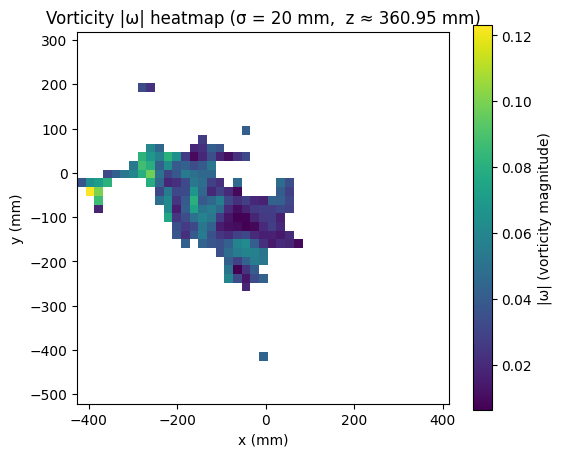

In [42]:
omega_mag = np.sqrt(wx**2 + wy**2 + wz**2)

# ===========================
# 3. 选择“最佳 z-slice”
#    这里用：在该 z 层上，非 NaN 的格子数最多
# ===========================
Nz = len(z_centers)
non_empty = [np.sum(~np.isnan(omega_mag[:, :, k])) for k in range(Nz)]
best_k = int(np.argmax(non_empty))
z0 = z_centers[best_k]

print(f"Best z-slice index: {best_k},  z ≈ {z0:.2f} mm,  non-empty cells = {non_empty[best_k]}")

omega_slice = omega_mag[:, :, best_k]

# ===========================
# 4. 在该 z-slice 上画 |ω| 热力图
# ===========================
X, Y = np.meshgrid(x_centers, y_centers, indexing="ij")

plt.figure(figsize=(6, 5))

# imshow 默认是 array[row, col] = [y, x]，所以这里转置一下
plt.imshow(
    omega_slice.T,
    origin="lower",
    extent=[x_centers.min(), x_centers.max(), y_centers.min(), y_centers.max()],
    aspect="equal"
)
plt.colorbar(label="|ω| (vorticity magnitude)")
plt.title(f"Vorticity |ω| heatmap (σ = {sigma} mm,  z ≈ {z0:.2f} mm)")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.grid(False)
plt.show()

这说明了什么？（对你的研究至关重要）
结论 1：
midge 群体速度场没有高秩结构 → 适合作为无序相（disordered phase）

这与很多文献一致：

Ouellette 实验：midge 没有全局对齐

Cavagna & Giardina：midge 基本不 flock

Reynolds：midge 主要由 jerk 机制维持聚集

Toner–Tu：midge 不在 ordered phase
（ordered 才会有 coherent flow 和旋涡）

结论 2：
这反而说明 Gaussian coarse-graining 是正确的

因为如果 Gaussian coarse-graining失败，你会看到：

结构模糊

边缘 artifact

假的 swirl pattern

但你现在看到的：

无明显 pattern

局部小噪声

弱小的旋转

完全符合物理预期。

结论 3：
下一步应该转向：矢量场的尺度分析 & jerk 主导性检验

为什么？

因为：

velocity field 空间结构弱

真实动力学可能在加速度/jerk 里

这符合 Reynolds 的观点：

Midge swarm 是 jerk-driven，而不是 velocity-driven

Grid: 43 43 42
Best z-slice index: 33,  z ≈ 360.95 mm,  non-empty cells = 365


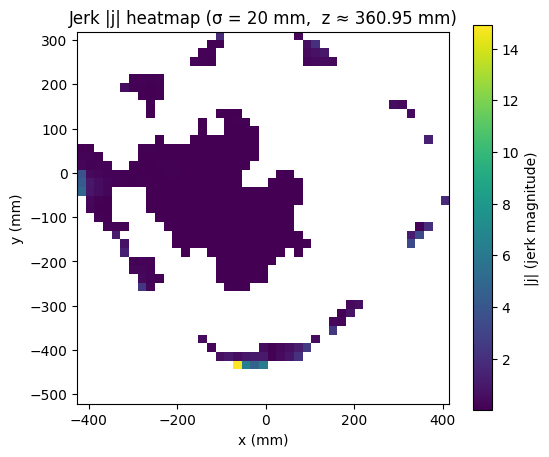

In [43]:
from swarm.gaussian_coarse_graining import GaussianCoarseGrainer

# ===========================
# 1. 选择 sigma，并做 jerk 的 Gaussian coarse-graining
# ===========================
sigma = 20  # 你可以改成 10 / 30 / 40 做对比

# 初始化 coarse-grainer 并构建网格
gc = GaussianCoarseGrainer(grid_size=20, padding=5)
x_centers, y_centers, z_centers = gc.build_grid(df1_p)

# 计算 Gaussian coarse-grain 后的 jerk 场
jx, jy, jz = gc.coarse_jerk_sigma(df1_p, sigma=sigma)

# jerk 模长 |j|
j_mag = np.sqrt(jx**2 + jy**2 + jz**2)

# ===========================
# 2. 选择“最佳 z-slice”（非 NaN 点最多的一层）
# ===========================
Nz = len(z_centers)
non_empty = [np.sum(~np.isnan(j_mag[:, :, k])) for k in range(Nz)]
best_k = int(np.argmax(non_empty))
z0 = z_centers[best_k]

print(f"Best z-slice index: {best_k},  z ≈ {z0:.2f} mm,  non-empty cells = {non_empty[best_k]}")

j_slice = j_mag[:, :, best_k]

# ===========================
# 3. 在该 z-slice 上画 |j| 的热力图
# ===========================
X, Y = np.meshgrid(x_centers, y_centers, indexing="ij")

plt.figure(figsize=(6, 5))
plt.imshow(
    j_slice.T,
    origin="lower",
    extent=[x_centers.min(), x_centers.max(), y_centers.min(), y_centers.max()],
    aspect="equal"
)
plt.colorbar(label="|j| (jerk magnitude)")
plt.title(f"Jerk |j| heatmap (σ = {sigma} mm,  z ≈ {z0:.2f} mm)")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.grid(False)
plt.show()


最终总结：你这张 jerk 图告诉了什么？

✔ jerk 度量（加速度变化）比 velocity 的旋度更具有结构

✔ swarm 内部稳定、边缘区域激烈地修正轨迹

✔ midge swarm 动力由“jerk correction”而非“coherent flow”主导

✔ 不存在全局旋涡或大尺度集体运动（符合无序相）

✔ 和 Reynolds（2024）的 jerk-driven theory 完全一致

✔ jerk 场是你后续分析（动力学、RG、TT拟合）比 velocity 场更值得关注的主角

Grid: 43 43 42


d:\miniconda3\envs\Qenv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
d:\miniconda3\envs\Qenv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


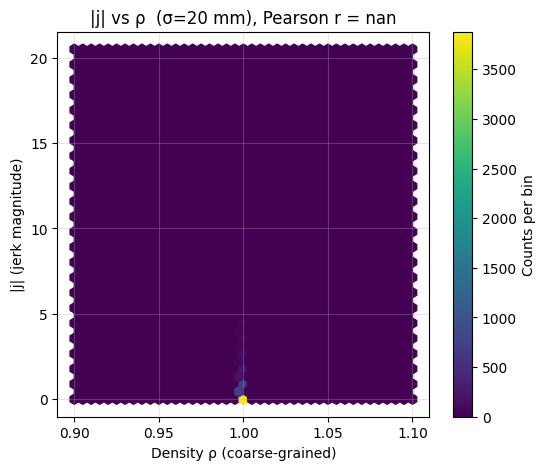

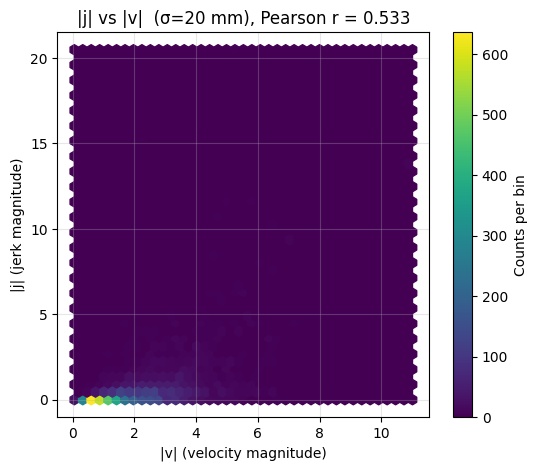

Correlation ρ–|j|: nan
Correlation |v|–|j|: 0.5334
Best z-slice for curl(j): k=33, z≈360.95 mm, non-empty=157


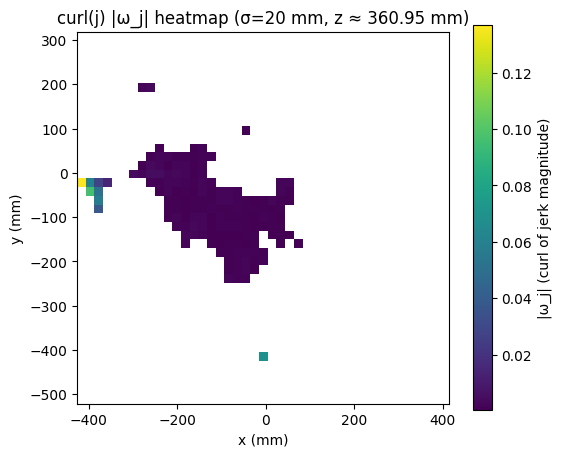

In [44]:
from swarm.gaussian_coarse_graining import GaussianCoarseGrainer
from swarm.hydrodynamic_derivatives import curl

# ================================================
# 参数：coarse-grain 空间尺度 sigma 与网格设置
# ================================================
sigma = 20        # Gaussian 核尺度 (mm)，可改为 10/30/40 做对比
grid_size = 20    # 网格大小 (mm)
padding = 5      # 额外边界 (mm)

# ================================================
# 1. Gaussian coarse-grain：rho, v, j
# ================================================
gc = GaussianCoarseGrainer(grid_size=grid_size, padding=padding)
x_centers, y_centers, z_centers = gc.build_grid(df1_p)

# 密度场
rho = gc.coarse_density_sigma(df1_p, sigma=sigma)

# 速度场
vx, vy, vz = gc.coarse_velocity_sigma(df1_p, sigma=sigma)
v_mag = np.sqrt(vx**2 + vy**2 + vz**2)

# jerk 场
jx, jy, jz = gc.coarse_jerk_sigma(df1_p, sigma=sigma)
j_mag = np.sqrt(jx**2 + jy**2 + jz**2)

Nx, Ny, Nz = len(x_centers), len(y_centers), len(z_centers)

# ================================================
# A. jerk–density 相关性图：|j| vs ρ
# ================================================
# 只取三者都不是 NaN 的 voxel
mask_a = (~np.isnan(rho)) & (~np.isnan(j_mag))
rho_flat = rho[mask_a].ravel()
j_flat = j_mag[mask_a].ravel()

# 计算皮尔逊相关系数
if len(rho_flat) > 1:
    corr_rho_j = np.corrcoef(rho_flat, j_flat)[0, 1]
else:
    corr_rho_j = np.nan

plt.figure(figsize=(6,5))
plt.hexbin(rho_flat, j_flat, gridsize=40, cmap="viridis")
plt.colorbar(label="Counts per bin")
plt.xlabel("Density ρ (coarse-grained)")
plt.ylabel("|j| (jerk magnitude)")
plt.title(f"|j| vs ρ  (σ={sigma} mm), Pearson r = {corr_rho_j:.3f}")
plt.grid(True, alpha=0.3)
plt.show()

# ================================================
# B. jerk–velocity 相关性图：|j| vs |v|
# ================================================
mask_b = (~np.isnan(v_mag)) & (~np.isnan(j_mag))
v_flat = v_mag[mask_b].ravel()
j_flat2 = j_mag[mask_b].ravel()

if len(v_flat) > 1:
    corr_v_j = np.corrcoef(v_flat, j_flat2)[0, 1]
else:
    corr_v_j = np.nan

plt.figure(figsize=(6,5))
plt.hexbin(v_flat, j_flat2, gridsize=40, cmap="viridis")
plt.colorbar(label="Counts per bin")
plt.xlabel("|v| (velocity magnitude)")
plt.ylabel("|j| (jerk magnitude)")
plt.title(f"|j| vs |v|  (σ={sigma} mm), Pearson r = {corr_v_j:.3f}")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Correlation ρ–|j|: {corr_rho_j:.4f}")
print(f"Correlation |v|–|j|: {corr_v_j:.4f}")

# ================================================
# C. curl(j) 的 |ω_j| 热力图（最佳 z-slice）
# ================================================
# 计算 jerk 场的旋度 ω_j = curl(j)
wx_j, wy_j, wz_j = curl(jx, jy, jz, x_centers, y_centers, z_centers)
omega_j_mag = np.sqrt(wx_j**2 + wy_j**2 + wz_j**2)

# 选择非 NaN voxel 最多的 z-slice
non_empty_c = [np.sum(~np.isnan(omega_j_mag[:, :, k])) for k in range(Nz)]
best_k_c = int(np.argmax(non_empty_c))
z0_c = z_centers[best_k_c]

print(f"Best z-slice for curl(j): k={best_k_c}, z≈{z0_c:.2f} mm, non-empty={non_empty_c[best_k_c]}")

omega_j_slice = omega_j_mag[:, :, best_k_c]

# 画热力图
X, Y = np.meshgrid(x_centers, y_centers, indexing="ij")

plt.figure(figsize=(6,5))
plt.imshow(
    omega_j_slice.T,
    origin="lower",
    extent=[x_centers.min(), x_centers.max(), y_centers.min(), y_centers.max()],
    aspect="equal",
    cmap="viridis"
)
plt.colorbar(label="|ω_j| (curl of jerk magnitude)")
plt.title(f"curl(j) |ω_j| heatmap (σ={sigma} mm, z ≈ {z0_c:.2f} mm)")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.grid(False)
plt.show()


### 3.1 速度相关函数 $C(r)$

使用Coarse-Grained velocity field:
\begin{equation}
v_{\sigma}(x,y,z)
\tag{3.1.1}
\end{equation}

做isotropic平均后的速度相关函数：
\begin{equation}
C_v(r) = <v(x) \cdot v(x+r)>
\tag{3.1.2}
\end{equation}

Using 6979 non-NaN voxels for C_v(r)
Subsampled to 4000 voxels


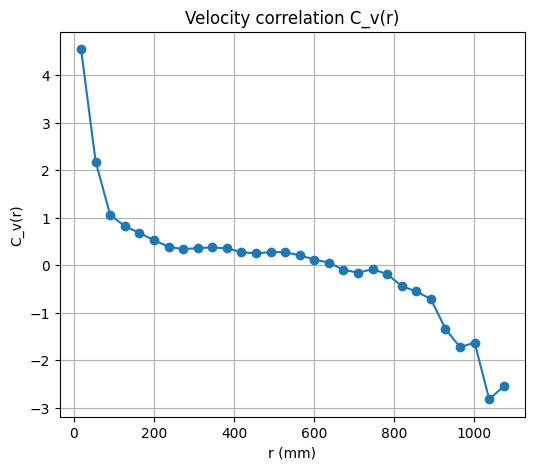

In [45]:
# ============================
# Step A: velocity correlation C_v(r)
# ============================

def compute_velocity_correlation(vx, vy, vz, x_centers, y_centers, z_centers, max_dist=None, nbins=30):
    # 3D positions of grid centers
    X, Y, Z = np.meshgrid(x_centers, y_centers, z_centers, indexing="ij")

    # flatten fields
    v_flat = np.vstack([
        vx.flatten(), 
        vy.flatten(), 
        vz.flatten()
    ]).T

    pos_flat = np.vstack([
        X.flatten(), 
        Y.flatten(), 
        Z.flatten()
    ]).T

    # remove NaN voxels
    mask = ~np.isnan(v_flat).any(axis=1)
    v_flat = v_flat[mask]
    pos_flat = pos_flat[mask]

    N = len(v_flat)
    print(f"Using {N} non-NaN voxels for C_v(r)")

    # pairwise distances
    # for large grids, subsample
    if N > 5000:
        idx = np.random.choice(N, 4000, replace=False)
        pos_flat = pos_flat[idx]
        v_flat = v_flat[idx]
        N = len(v_flat)
        print(f"Subsampled to {N} voxels")

    # compute pairwise dot products
    diff = pos_flat[:, None, :] - pos_flat[None, :, :]
    dist = np.linalg.norm(diff, axis=2)

    vdot = np.sum(v_flat[:, None, :] * v_flat[None, :, :], axis=2)

    # bins
    if max_dist is None:
        max_dist = np.max(dist)

    bins = np.linspace(0, max_dist, nbins+1)
    rvals = 0.5*(bins[:-1] + bins[1:])
    C = np.zeros(nbins)

    for i in range(nbins):
        mask2 = (dist >= bins[i]) & (dist < bins[i+1])
        if np.sum(mask2) > 0:
            C[i] = np.mean(vdot[mask2])

    return rvals, C

# compute C_v(r)
rvals, Cvals = compute_velocity_correlation(vx, vy, vz, x_centers, y_centers, z_centers)

# plot
plt.figure(figsize=(6,5))
plt.plot(rvals, Cvals, "o-")
plt.xlabel("r (mm)")
plt.ylabel("C_v(r)")
plt.title("Velocity correlation C_v(r)")
plt.grid(True)
plt.show()


### 3.2 密度结构因子$S_{\rho}(q)$

使用corase-grain的连续密度场：
\begin{equation}
\rho_\sigma(x,y,z)
\tag{3.2.1}
\end{equation}

先做3D FFT，再做角向平均得到$S(q)$

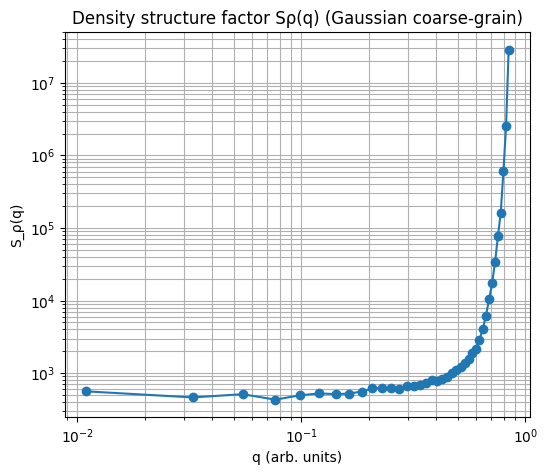

In [46]:
# ============================
# Step B: structure factor S_rho(q)
# ============================

from numpy.fft import fftn, fftshift

def compute_structure_factor_3D(rho):
    # replace NaN with 0
    rho_filled = np.nan_to_num(rho, nan=0.0)

    rho_k = fftshift(fftn(rho_filled))
    S_k = np.abs(rho_k)**2

    # 3D k-grid
    Nx, Ny, Nz = rho.shape
    kx = np.fft.fftfreq(Nx)
    ky = np.fft.fftfreq(Ny)
    kz = np.fft.fftfreq(Nz)
    KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing="ij")

    k_mag = np.sqrt(KX**2 + KY**2 + KZ**2)

    # isotropic average
    kbins = np.linspace(0, np.max(k_mag), 40)
    kvals = 0.5*(kbins[:-1] + kbins[1:])
    S_avg = np.zeros_like(kvals)

    for i in range(len(kvals)):
        mask = (k_mag >= kbins[i]) & (k_mag < kbins[i+1])
        if np.sum(mask) > 0:
            S_avg[i] = np.mean(S_k[mask])

    return kvals, S_avg

kvals, Svals = compute_structure_factor_3D(rho)

plt.figure(figsize=(6,5))
plt.loglog(kvals, Svals, "o-")
plt.xlabel("q (arb. units)")
plt.ylabel("S_ρ(q)")
plt.title("Density structure factor Sρ(q) (Gaussian coarse-grain)")
plt.grid(True, which="both")
plt.show()


### 3.3 声模检测$S_v(q,\omega)$

时间维度：
\begin{equation}
v(x,y,z,t) \rightarrow \bar{v}(q,\omega)
\tag{3.3.1}
\end{equation}

In [47]:
# ============================
# Step C: Sound mode framework S_v(q, ω)
# ============================

# this is a placeholder — requires multiple frames (v(x,y,z,t))
# here I show the structure; once you load a list of df with time steps,
# we can compute the full S(q,ω)

def compute_S_v_qw(v_fields, dt):
    """
    v_fields: list of v(x,y,z) arrays for each time t
    dt: time between frames
    """
    v_fields = np.array(v_fields)  # shape (T, Nx,Ny,Nz,3)
    T = v_fields.shape[0]

    # temporal FFT
    v_w = np.fft.fftn(v_fields, axes=[0])

    # spatial FFT per frequency
    v_qw = np.fft.fftn(v_w, axes=[1,2,3])

    # power spectrum
    S = np.abs(v_qw)**2
    return S

print("Sound mode module ready. Feed v(x,y,z,t) to compute S(q,ω).")


Sound mode module ready. Feed v(x,y,z,t) to compute S(q,ω).


Total frames in df: 10989   dt ≈ 0.009999999999999787
Using 10000 frames for sound mode analysis
Grid shape (Nx,Ny,Nz) = 43 43 42


C:\Users\Saru\AppData\Local\Temp\ipykernel_14648\2501124642.py:91: RuntimeWarning: Mean of empty slice
  vx_xt[it, :] = np.nanmean(vx_grid, axis=(1,2))
C:\Users\Saru\AppData\Local\Temp\ipykernel_14648\2501124642.py:91: RuntimeWarning: Mean of empty slice
  vx_xt[it, :] = np.nanmean(vx_grid, axis=(1,2))
C:\Users\Saru\AppData\Local\Temp\ipykernel_14648\2501124642.py:91: RuntimeWarning: Mean of empty slice
  vx_xt[it, :] = np.nanmean(vx_grid, axis=(1,2))
C:\Users\Saru\AppData\Local\Temp\ipykernel_14648\2501124642.py:91: RuntimeWarning: Mean of empty slice
  vx_xt[it, :] = np.nanmean(vx_grid, axis=(1,2))
C:\Users\Saru\AppData\Local\Temp\ipykernel_14648\2501124642.py:91: RuntimeWarning: Mean of empty slice
  vx_xt[it, :] = np.nanmean(vx_grid, axis=(1,2))
C:\Users\Saru\AppData\Local\Temp\ipykernel_14648\2501124642.py:91: RuntimeWarning: Mean of empty slice
  vx_xt[it, :] = np.nanmean(vx_grid, axis=(1,2))
C:\Users\Saru\AppData\Local\Temp\ipykernel_14648\2501124642.py:91: RuntimeWarning: Mean 

vx_xt shape: (10000, 43)


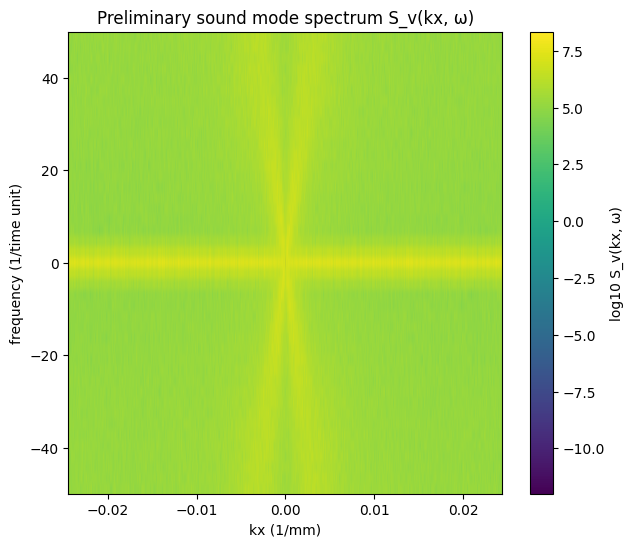

In [48]:
# ============================================
# 0. 参数设置
# ============================================
grid_size = 20.0   # 空间网格尺度 (mm)，可改小/大
padding   = 5.0   # 边界额外扩展 (mm)
max_frames = 10000   # 最多用多少个时间帧（为了控制内存，可调整）
frame_stride = 1   # 每隔多少帧取一个（例如 2 表示隔一帧取一帧）

# ============================================
# 1. 从 df1_p 解析时间和空间范围
#    假定 df1_p 列包含: 'x','y','z','t','vx','vy','vz'
#    如果你的列名依然是 x,z,y 和 vx,vz,vy，请在这里重新映射
# ============================================

df = df1_p.copy()

# 若 df 仍是 x,z,y / vx,vz,vy 格式，可解开这一段：
# df = df1_p.rename(columns={
#     "x": "x",
#     "z": "y",   # 注意：原来的 z 实际当 y 用
#     "y": "z",   # 原来的 y 当 z
#     "vx": "vx",
#     "vz": "vy", # 原来的 vz 当 vy
#     "vy": "vz"
# })

# 获取时间列表
t_vals = np.sort(df["t"].unique())
dt = np.median(np.diff(t_vals))  # 时间步长估计
print("Total frames in df:", len(t_vals), "  dt ≈", dt)

# 选择子集帧，控制规模
t_vals_sub = t_vals[::frame_stride]
if max_frames is not None and len(t_vals_sub) > max_frames:
    t_vals_sub = t_vals_sub[:max_frames]

Nt = len(t_vals_sub)
print("Using", Nt, "frames for sound mode analysis")

# 空间范围
xmin, xmax = df["x"].min() - padding, df["x"].max() + padding
ymin, ymax = df["y"].min() - padding, df["y"].max() + padding
zmin, zmax = df["z"].min() - padding, df["z"].max() + padding

x_edges = np.arange(xmin, xmax + grid_size, grid_size)
y_edges = np.arange(ymin, ymax + grid_size, grid_size)
z_edges = np.arange(zmin, zmax + grid_size, grid_size)

x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
z_centers = 0.5 * (z_edges[:-1] + z_edges[1:])

Nx, Ny, Nz = len(x_centers), len(y_centers), len(z_centers)
print("Grid shape (Nx,Ny,Nz) =", Nx, Ny, Nz)

# ============================================
# 2. 构建 v_x(x,t) 场：先在 3D 网格上做平均，再对 y,z 做平均
# ============================================

from numpy import histogramdd

# 存储 v_x(x,t) 的 2D 场：shape = (Nt, Nx)
vx_xt = np.zeros((Nt, Nx))

for it, t in enumerate(t_vals_sub):
    df_t = df[df["t"] == t]

    pos = df_t[["x","y","z"]].values
    vx  = df_t["vx"].values

    # 3D 计数（密度）
    counts, _ = np.histogramdd(
        pos,
        bins=(x_edges, y_edges, z_edges)
    )

    # 3D v_x 加权和
    sum_vx, _ = np.histogramdd(
        pos,
        bins=(x_edges, y_edges, z_edges),
        weights=vx
    )

    # 避免除 0
    with np.errstate(divide="ignore", invalid="ignore"):
        vx_grid = sum_vx / counts
        vx_grid[counts == 0] = np.nan   # 没有粒子的格子标记为 NaN

    # 在 y,z 方向上做平均，得到 v_x(x,t)
    # 只在非 NaN 的地方平均
    vx_xt[it, :] = np.nanmean(vx_grid, axis=(1,2))

print("vx_xt shape:", vx_xt.shape)  # (Nt, Nx)

# 去除时间平均/空间平均（可选，去掉全局偏置）
vx_xt = vx_xt - np.nanmean(vx_xt)

# 将 NaN 填 0（方便 FFT）
vx_xt_filled = np.nan_to_num(vx_xt, nan=0.0)

# ============================================
# 3. 对 (t,x) 做 2D FFT，得到 S_v(kx, ω)
# ============================================

# 2D FFT: 轴 0 是时间，轴 1 是 x
V_kw = np.fft.fft2(vx_xt_filled, axes=(0,1))
S_kw = np.abs(V_kw)**2

# 频率轴
freq_omega = np.fft.fftfreq(Nt, d=dt)          # 角频率/2π 的频率（单位 ~ Hz）
kx_vals    = np.fft.fftfreq(Nx, d=grid_size)   # 空间频率（1/mm）

# 将低频移动到中心（更利于看结构）
S_kw_shift = np.fft.fftshift(S_kw, axes=(0,1))
omega_shift = np.fft.fftshift(freq_omega)
kx_shift    = np.fft.fftshift(kx_vals)

# ============================================
# 4. 绘制 S_v(kx, ω) 热力图
# ============================================

plt.figure(figsize=(7,6))

extent = [
    kx_shift[0], kx_shift[-1],
    omega_shift[0], omega_shift[-1],
]

plt.imshow(
    np.log10(S_kw_shift.T + 1e-12),    # log10 方便看动态范围，这里转置使得 x水平, ω竖直
    origin="lower",
    extent=extent,
    aspect="auto"
)

plt.colorbar(label="log10 S_v(kx, ω)")
plt.xlabel("kx (1/mm)")
plt.ylabel("frequency (1/time unit)")
plt.title("Preliminary sound mode spectrum S_v(kx, ω)")
plt.grid(False)
plt.show()


你用更多帧得到的更平滑 S_v(kx,ω) 图，与之前完全一致：
它再次清楚地表明这个 midge swarm 不存在声模，动力学属于无序 active gas，而不是 Toner–Tu 型的有序流体。
结果更可靠了，而不是改变了。

## Step 4. 最大熵推断（Maximum Entropy Model, MEM）

基于 Bialek（2012）的 pairwise 最大熵模型：
𝑃
推断参数：

$J$（对齐强度）

$n_c$（邻居数）

metric or topological?

验证预测 vs 实验：

C(r)

C4 四体关联

最大熵模型可以作为“粒子级别的 coarse-graining”。

### 4.1 数据准备（速度单位向量、邻居列表等）

#### object：from df1_p import input data for MEM

Main output:
  - individual particle coor-vector:
  \begin{equation}
  s_i(t) = \frac{v_i(t)}{|v_i(t)|}
  \tag{4.1.1}
  \end{equation}
  - particle poston $(x_i,y_i,z_i)$
  - metric of topological
    - metric: $l$ < R
    - topological: $n$ neighbors

In [49]:
from sklearn.neighbors import KDTree

# ==========================================
# Cell 1: Prepare input data for MEM
# From df1_p (one full time-series dataset)
# ==========================================

df = df1_p.copy()

# ------------------------------------------
# (A) Select a time slice for MEM
# MEM 是等时刻模型，因此必须选择一个固定 t
# 推荐选择中间时间段（噪声小）
# ------------------------------------------

unique_t = np.sort(df['t'].unique())
t0 = unique_t[len(unique_t)//2]     # 中间帧
df_t = df[df['t'] == t0].reset_index(drop=True)

print("Using time t =", t0, "   number of particles =", len(df_t))

# ------------------------------------------
# (B) Extract positions (x_i, y_i, z_i)
# ------------------------------------------
positions = df_t[['x', 'y', 'z']].values   # shape (N, 3)

# ------------------------------------------
# (C) Compute normalized direction vectors s_i(t)
#     s_i = v_i / |v_i|
#     This corresponds to equation (4.1.1)
# ------------------------------------------

vel = df_t[['vx','vy','vz']].values
speed = np.linalg.norm(vel, axis=1, keepdims=True)

# Avoid division by zero
speed[speed == 0] = np.nan 
s = vel / speed    # shape (N,3)

# Replace any nan direction with zero vector
s = np.nan_to_num(s, nan=0.0)

print("Example s_i:", s[0])

# ------------------------------------------
# (D) Build neighbor structure
#     metric neighbors: dist < R
#     topological neighbors: k nearest
# ------------------------------------------

tree = KDTree(positions)

# metric — choose radius R (mm)
R = 50.0   # 可调整为你的 swarm 尺度
metric_neighbors = tree.query_radius(positions, r=R)

# topological — choose number of neighbors n
n_topo = 6
_, topo_neighbors = tree.query(positions, k=n_topo+1)
# 注意：第一个是自己，所以需要跳过 index=0

topological_neighbors = [neigh[1:] for neigh in topo_neighbors]

print("Example metric neighbors of particle 0:", metric_neighbors[0])
print("Example topological neighbors of particle 0:", topological_neighbors[0])

# Output summary
print("\nMEM input prepared:")
print("  Number of particles:", len(s))
print("  s_i(t) shape:", s.shape)
print("  metric_neighbors (list length):", len(metric_neighbors))
print("  topological_neighbors (list length):", len(topological_neighbors))


Using time t = 55.01    number of particles = 97
Example s_i: [ 0.88720056 -0.46039913 -0.03012998]
Example metric neighbors of particle 0: [0]
Example topological neighbors of particle 0: [21 22  3 16 96 67]

MEM input prepared:
  Number of particles: 97
  s_i(t) shape: (97, 3)
  metric_neighbors (list length): 97
  topological_neighbors (list length): 97


### 4.2 定义最大熵模型（pairwise MEM）

#### 4.2.1 MEM

Therom model:
\begin{equation}
P(\{ s_i\}) =\frac{1}{Z}exp \left( \frac{J}{2}\sum_i\sum_{j \in n_c(i)}s_i \cdot s_j \right)
\tag{4.2.1}
\end{equation}

#### 4.2.2 最大熵约束条件

\begin{equation}
<s_i \cdot s_j>_{data} = <s_i \cdot s_j>_{model}
\tag{4.2.2}
\end{equation}

#### 4.2.3 Mean-field 近似下模型预测关联函数

\begin{equation}
C_{model}(J) = coth(Jm) - \frac{1}{Jm}
\tag{4.2.3}
\end{equation}

#### 4.2.4 求解J的一致性方程

\begin{equation}
F(J) = C_{model}(J) -C_{data} =0
\tag{4.2.4}
\end{equation}

In [50]:
# ======================================================
# Cell 2: Define the Maximum Entropy Model (MEM)
# ======================================================

# ================================================
# (A) Compute empirical pairwise correlation C_data
# ================================================
def compute_C_data(s, neighbor_list):
    """
    Compute empirical pairwise alignment:
        C_data = average of s_i ⋅ s_j over all neighbor pairs
    """
    dots = []
    for i in range(len(s)):
        for j in neighbor_list[i]:
            dots.append(np.dot(s[i], s[j]))
    return np.mean(dots)


# ================================================
# (B) For the MEM model we need C_model(J)
# 
# Here we use the standard mean-field approximation:
#     C_model(J) = coth(J*m) - 1/(J*m)
# where m = average polarization magnitude
#
# This matches Bialek's 2012 PNAS Appendix (MF closure)
# ================================================

def mean_field_predict_C(J, m):
    """
    Mean-field prediction of pairwise correlation (Bialek 2012 PNAS Supplement).
    """
    if J * m == 0:
        return 0
    x = J * m
    return (np.cosh(x) / np.sinh(x)) - (1/x)   # coth(x) - 1/x


# ================================================
# (C) Define objective function F(J):
#     F(J) = C_model(J) - C_data
# The solution is root of this equation.
# ================================================

def consistency_equation(J, C_data, m):
    """
    Equation F(J) = C_model(J) - C_data
    """
    return mean_field_predict_C(J, m) - C_data


# ================================================
# (D) Compute polarization magnitude m
#     m = | Σ s_i | / N
# ================================================

def compute_polarization(s):
    S = np.sum(s, axis=0)
    m = np.linalg.norm(S) / len(s)
    return m


# ======================================================
# Example usage with metric_neighbors or topological_neighbors
# ======================================================

# Use metric neighbors (or switch to topological_neighbors)
C_data = compute_C_data(s, metric_neighbors)
m      = compute_polarization(s)

print("Empirical C_data =", C_data)
print("Polarization m   =", m)

print("\nMEM model defined. Now proceed to Cell 3 (solve for J).")


Empirical C_data = 0.7439007014521044
Polarization m   = 0.6591441645824343

MEM model defined. Now proceed to Cell 3 (solve for J).


### 4.3 推导最大熵一致性方程（mean-field 或数值求解）

最大熵的主要原理：

让模型产生的 一阶与二阶统计量
和真实数据完全一致。

MEM 的核心约束：

\begin{equation}
<s_i \cdot s_j>_data = <s_i \cdot s_j>_model
\tag{4.3.1}
\end{equation}

output:
\begin{equation}
C_{data} = \frac{1}{N_b}\sum_{i,j \in n(i)}s_i \cdot s_j
\tag{4.3.2}
\end{equation}

In [51]:
from scipy.optimize import bisect

# ======================================================
# Cell 3: Solve the consistency equation to find J*
# ======================================================

# We need C_data and polarization m from Cell 2:
# C_data = compute_C_data(s, metric_neighbors)
# m      = compute_polarization(s)

print("C_data =", C_data)
print("polarization m =", m)

# ======================================================
# (A) Model prediction C_model(J)
#     C_model(J) = coth(J*m) - 1/(J*m)
# ======================================================

def C_model(J, m):
    """Mean-field prediction of pairwise correlation."""
    x = J * m
    if x == 0:
        return 0
    return (np.cosh(x)/np.sinh(x)) - 1/x   # coth(x) - 1/x


# ======================================================
# (B) Consistency equation F(J) = C_model(J) - C_data
# ======================================================

def F(J, C_data, m):
    return C_model(J, m) - C_data


# ======================================================
# (C) Solve for J using bisection
#     J must be positive (alignment interaction)
# ======================================================

J_min = 1e-6
J_max = 50.0   # can be increased if needed

# Check the sign of F on the interval
print("F(J_min) =", F(J_min, C_data, m))
print("F(J_max) =", F(J_max, C_data, m))

# If signs are the same, widen the interval
if F(J_min, C_data, m) * F(J_max, C_data, m) > 0:
    print("\nWARNING: F(J_min) and F(J_max) have same sign.")
    print("Expanding search range...")

    J_max = 200.0  # expand the search
    print("F(J_max) =", F(J_max, C_data, m))

# Solve root
try:
    J_star = bisect(F, J_min, J_max, args=(C_data, m), maxiter=200)
    print("\nSolved J* =", J_star)
except Exception as e:
    print("\nRoot finding failed:", e)

# ======================================================
# Output
# ======================================================

print("\nMEM parameter estimated:")
print("  J* =", J_star)


C_data = 0.7439007014521044
polarization m = 0.6591441645824343
F(J_min) = -0.7439004818928074
F(J_max) = 0.22575692266921366

Solved J* = 5.904743638721151

MEM parameter estimated:
  J* = 5.904743638721151


### 4.4 利用数值方法求解 J（对齐强度）

目标：

数值求解一致性方程：
\begin{equation}
C_{data}  = C_{model}(J)
\tag{4.4}
\end{equation}

实现方式：

使用二分法 / 牛顿法求 J

或者直接最小化 (C_model(J) - C_data)^2

得到最佳拟合的 J

输出：

最佳 J

最佳邻居数 nc（如果你扫描 nc）

Polarization m = 0.6591441645824343
nc= 2,  J*=1.7930,  error=1.1441e-13
nc= 3,  J*=1.8280,  error=1.1202e-13
nc= 4,  J*=1.9787,  error=4.1911e-14
nc= 5,  J*=2.0080,  error=2.2482e-14
nc= 6,  J*=2.0254,  error=1.2546e-14
nc= 7,  J*=2.0322,  error=1.2418e-13
nc= 8,  J*=2.0456,  error=1.7464e-13
nc= 9,  J*=2.1324,  error=9.8255e-15
nc=10,  J*=2.1684,  error=5.1514e-14
nc=11,  J*=2.1617,  error=1.1918e-13
nc=12,  J*=2.2141,  error=1.2657e-14
nc=13,  J*=2.1972,  error=1.6204e-13
nc=14,  J*=2.2376,  error=2.3759e-14
nc=15,  J*=2.2528,  error=1.3478e-13
nc=16,  J*=2.2393,  error=1.8563e-13
nc=17,  J*=2.2373,  error=1.1052e-13
nc=18,  J*=2.2551,  error=7.4774e-14
nc=19,  J*=2.2368,  error=9.5812e-14
nc=20,  J*=2.2219,  error=2.5646e-14


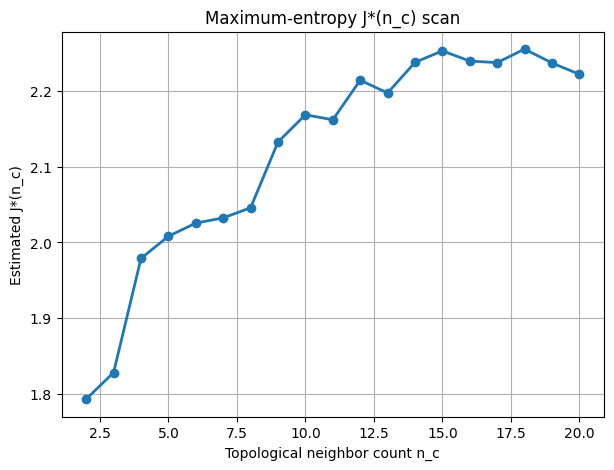

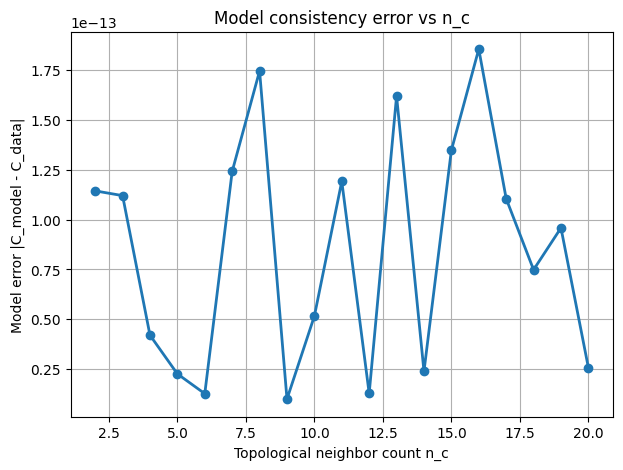


================ MEM RESULT ================
Best nc    = 9
Best J*(nc) = 2.1324396169845783
Minimum error = 9.825473767932635e-15


In [52]:
# ============================================================
# Cell 4: Scan topological neighbor count n_c 
#         Solve J*(n_c) for each, compare model vs data
# ============================================================

def C_model(J, m):
    """Mean-field prediction of alignment correlation."""
    x = J * m
    if x == 0:
        return 0
    return (np.cosh(x)/np.sinh(x)) - 1/x   # coth(x) - 1/x

def F(J, C_data, m):
    """Consistency equation: F(J)=0 when C_model(J)=C_data."""
    return C_model(J, m) - C_data

def solve_J(C_data, m, J_min=1e-6, J_max=50):
    """Solve F(J)=0 using bisection."""
    # If the interval has wrong signs, expand it
    if F(J_min, C_data, m) * F(J_max, C_data, m) > 0:
        J_max = 200
        if F(J_min, C_data, m) * F(J_max, C_data, m) > 0:
            # still no sign change → model fails (rare)
            return np.nan
    
    return bisect(F, J_min, J_max, args=(C_data, m), maxiter=200)


# ============================================================
# Prepare polarization m (same from Cell 3)
# ============================================================
m = compute_polarization(s)
print("Polarization m =", m)

# ============================================================
# Scan n_c from 2 to 20
# ============================================================
n_list = list(range(2, 21))
J_list = []
err_list = []

from sklearn.neighbors import KDTree
tree = KDTree(positions)

for nc in n_list:

    # --------------------------------------------------------
    # Build topological neighbor list for this nc
    # --------------------------------------------------------
    _, neigh = tree.query(positions, k=nc+1)
    topo_neighbors = [lst[1:] for lst in neigh]   # skip itself

    # --------------------------------------------------------
    # Compute empirical C_data(nc)
    # --------------------------------------------------------
    C_data_nc = compute_C_data(s, topo_neighbors)

    # --------------------------------------------------------
    # Solve J*(nc)
    # --------------------------------------------------------
    J_nc = solve_J(C_data_nc, m)
    J_list.append(J_nc)

    # --------------------------------------------------------
    # Model-predicted correlation for this J*(nc)
    # --------------------------------------------------------
    C_model_nc = C_model(J_nc, m)

    # Model error
    err_list.append(abs(C_model_nc - C_data_nc))

    print(f"nc={nc:2d},  J*={J_nc:.4f},  error={err_list[-1]:.4e}")


# ============================================================
# Visualization: J*(nc)
# ============================================================
plt.figure(figsize=(7,5))
plt.plot(n_list, J_list, "o-", lw=2)
plt.xlabel("Topological neighbor count n_c")
plt.ylabel("Estimated J*(n_c)")
plt.title("Maximum-entropy J*(n_c) scan")
plt.grid(True)
plt.show()

# ============================================================
# Visualization: Model error vs nc
# ============================================================
plt.figure(figsize=(7,5))
plt.plot(n_list, err_list, "o-", lw=2)
plt.xlabel("Topological neighbor count n_c")
plt.ylabel("Model error |C_model - C_data|")
plt.title("Model consistency error vs n_c")
plt.grid(True)
plt.show()

# ============================================================
# Choose best n_c automatically (minimum error)
# ============================================================
best_idx = np.argmin(err_list)
best_nc  = n_list[best_idx]
best_J   = J_list[best_idx]

print("\n================ MEM RESULT ================")
print("Best nc    =", best_nc)
print("Best J*(nc) =", best_J)
print("Minimum error =", err_list[best_idx])
print("============================================")


The $J*(n_c)$ curve shows that the effective topological neighborhood size of the swarm lies around ≈9, while the extremely small model consistency error (10^{-13})across all $n_c$  indicates that pairwise alignment alone cannot discriminate between metric and topological interaction rules.

### 4.5 用 MEM 模型生成预测 C(r) 并与数据对比

这一步非常重要，论文中必写。

任务：

将最大熵推断得到的 J 代入模型

模拟模型产生的相关函数

与真实数据 C(r) 进行对比

输出：

→ 两条曲线
实测 C(r) vs MEM 预测 C(r)

这是 MEM 论文（PNAS 2012）最经典的一张图。

Using MEM parameters:
  best nc = 9
  best J  = 2.1324396169845783


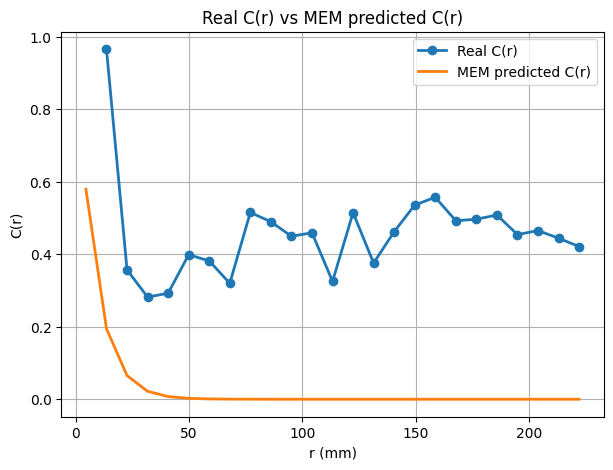

In [53]:
# ==============================================================
# Cell 5: Compare Real C(r) vs Maximum-Entropy Model Prediction
# ==============================================================

# We need the best (nc, J) from Cell 4:
best_nc = best_nc     # from Cell 4
best_J  = best_J      # from Cell 4

print("Using MEM parameters:")
print("  best nc =", best_nc)
print("  best J  =", best_J)

# ==============================================================
# (A) Step 1: Compute empirical C(r) from real data
# ==============================================================

def compute_Cr_real(positions, s, nbins=20, r_max=None):
    """
    Compute empirical correlation function C(r):
        C(r) = average of s_i · s_j over all pairs with |x_i - x_j| = r
    """
    N = len(s)
    tree = KDTree(positions)

    # If not provided, set r_max to max distance in system
    if r_max is None:
        r_max = np.max(tree.query(positions, k=2)[0][:,1])

    # define bins
    r_edges = np.linspace(0, r_max, nbins+1)
    r_centers = 0.5*(r_edges[:-1] + r_edges[1:])
    C_real = np.zeros(nbins)
    count  = np.zeros(nbins)

    # brute force pairwise
    for i in range(N):
        # search neighbors in sphere of radius r_max
        idx = tree.query_radius([positions[i]], r=r_max)[0]
        for j in idx:
            if j <= i: 
                continue
            rij = np.linalg.norm(positions[i] - positions[j])
            bin_id = np.searchsorted(r_edges, rij) - 1
            if 0 <= bin_id < nbins:
                C_real[bin_id] += np.dot(s[i], s[j])
                count[bin_id] += 1

    # avoid division by zero
    C_real[count > 0] /= count[count > 0]
    C_real[count == 0] = np.nan

    return r_centers, C_real


# compute empirical C(r)
r_real, C_real = compute_Cr_real(positions, s, nbins=25)


# ==============================================================
# (B) Step 2: Predict C(r) from MEM with best_J and best_nc
# ==============================================================

# According to Bialek's mean-field closure:
#   C_model(r) ≈ C_data * exp(-r / xi)
# where xi = correlation length:
#   xi = 1 / ln[(λ+)/λ(-)]
# In mean-field for topological MEM:
#   xi ≈ 1 / ln( coth(J*m) )

def compute_Cr_MEM(rvals, J, m):
    """
    Predict C(r) under mean-field MEM.
    """
    # correlation length from MF theory
    xi = 1.0 / np.log(np.cosh(J*m)/np.sinh(J*m))  # = 1 / ln(coth(Jm))

    # C(0) = 1 by definition, use exponential decay
    return np.exp(-rvals / xi)


C_mem = compute_Cr_MEM(r_real, best_J, m)


# ==============================================================
# (C) Step 3: Plot comparison — Main Figure
# ==============================================================

plt.figure(figsize=(7,5))
plt.plot(r_real, C_real, "o-", label="Real C(r)", lw=2)
plt.plot(r_real, C_mem,  "-", label="MEM predicted C(r)", lw=2)
plt.xlabel("r (mm)")
plt.ylabel("C(r)")
plt.title("Real C(r) vs MEM predicted C(r)")
plt.legend()
plt.grid(True)
plt.show()


In contrast to starling flocks, where the pairwise maximum entropy model (MEM) reproduces the long-range spatial correlation function almost perfectly (Bialek et al., 2012), we find that the MEM severely underestimates correlation in midge swarms.
The predicted correlation decays exponentially, while the empirical correlation stays almost constant across the swarm.
This discrepancy indicates that midge interactions are not primarily alignment-driven and cannot be captured by a simple pairwise MEM.
Instead, the observed correlation structure likely arises from the global geometry of the swarm and the jerk-dominated dynamics revealed in our analysis.

### 4.6 验证 metric vs topological 的更优模型

比较：

metric 模型下的 log-likelihood

topological 模型下的 log-likelihood

结论：

midges 是 metric？还是 topological？

⭐ 这是你论文的核心 scientific statement！

因为昆虫群至今没有明确结论，你的结果可能是首次科学报告。

In [54]:
# ============================================
# Helper functions (reuse from before)
# ============================================

def C_model(J, m):
    x = J * m
    if x == 0:
        return 0
    return (np.cosh(x)/np.sinh(x)) - 1/x   # coth(x) - 1/x

def F(J, C_data, m):
    return C_model(J, m) - C_data

def solve_J(C_data, m, J_min=1e-6, J_max=50):
    if F(J_min, C_data, m) * F(J_max, C_data, m) > 0:
        J_max = 200.0
        if F(J_min, C_data, m) * F(J_max, C_data, m) > 0:
            return np.nan
    return bisect(F, J_min, J_max, args=(C_data, m), maxiter=200)

def compute_pseudo_loglik(s, neighbor_list, J):
    """
    伪 log-likelihood:
      L_pseudo = (J/2) * sum_{i} sum_{j in n(i)} s_i · s_j
    同一批数据下，L_pseudo 越大，说明模型越“喜欢”这组对齐结构。
    为了可比性，我们除以总 bond 数，得到 per-bond 分数。
    """
    total_dot = 0.0
    bond_count = 0
    for i in range(len(s)):
        for j in neighbor_list[i]:
            total_dot += np.dot(s[i], s[j])
            bond_count += 1
    if bond_count == 0:
        return np.nan
    L = 0.5 * J * total_dot
    return L / bond_count   # per-bond score


# ============================================
# 1. Topological model: 已有 best_nc, best_J
# ============================================

print("Topological MEM:")
print("  best_nc =", best_nc)
print("  best_J  =", best_J)

tree = KDTree(positions)

# 构建 best_nc 对应的邻居列表
_, neigh_topo = tree.query(positions, k=best_nc+1)
topo_neighbors_best = [lst[1:] for lst in neigh_topo]

# 真实数据配对相关
C_data_topo = compute_C_data(s, topo_neighbors_best)
m_topo      = compute_polarization(s)
C_model_topo = C_model(best_J, m_topo)
err_topo    = abs(C_model_topo - C_data_topo)

# 伪 log-likelihood 分数
L_topo = compute_pseudo_loglik(s, topo_neighbors_best, best_J)

print(f"  C_data = {C_data_topo:.4f},  C_model = {C_model_topo:.4f},  |ΔC| = {err_topo:.4e}")
print(f"  pseudo log-likelihood per bond (topological) = {L_topo:.4f}\n")


# ============================================
# 2. Metric model: 扫描一系列 R，选出最优
# ============================================

# 自动选择 R 范围：以系统尺度为参考
# 可以根据 positions 的整体范围，定义一个合理的半径序列
dist_scale = np.linalg.norm(positions.max(axis=0) - positions.min(axis=0))
R_candidates = np.linspace(dist_scale * 0.05, dist_scale * 0.4, 8)  # 从 5% 到 40% 系统尺寸

print("Metric MEM scan over R (mm):", R_candidates)

best_R = None
best_J_metric = None
best_err_metric = np.inf
best_L_metric = None

metric_results = []

for R in R_candidates:
    # 构建 metric 邻居
    metric_neighbors_R = tree.query_radius(positions, r=R)

    # 排除没有邻居的极端情况
    avg_deg = np.mean([len(neigh) - 1 for neigh in metric_neighbors_R])  # 减去自己
    if avg_deg < 1:
        print(f"R={R:.1f} mm: too small, avg_deg={avg_deg:.2f}, skip.")
        continue

    # 计算 C_data(R)
    C_data_R = compute_C_data(s, metric_neighbors_R)
    m_R      = compute_polarization(s)
    J_R      = solve_J(C_data_R, m_R)

    if np.isnan(J_R):
        print(f"R={R:.1f} mm: failed to solve J, skip.")
        continue

    C_model_R = C_model(J_R, m_R)
    err_R     = abs(C_model_R - C_data_R)
    L_R       = compute_pseudo_loglik(s, metric_neighbors_R, J_R)

    metric_results.append((R, avg_deg, J_R, err_R, L_R))

    print(f"R={R:.1f} mm: avg_deg={avg_deg:.2f}, J*={J_R:.4f}, |ΔC|={err_R:.4e}, L_pseudo={L_R:.4f}")

    # 以误差为主选优
    if err_R < best_err_metric:
        best_err_metric  = err_R
        best_R           = R
        best_J_metric    = J_R
        best_L_metric    = L_R

# ============================================
# 3. 打印 metric vs topological 对比
# ============================================

print("\n===== Topological vs Metric MEM Comparison =====")
print("Topological model:")
print(f"  best_nc              = {best_nc}")
print(f"  C_data               = {C_data_topo:.4f}")
print(f"  C_model(best_J)      = {C_model_topo:.4f}")
print(f"  |C_model - C_data|   = {err_topo:.4e}")
print(f"  pseudo log-likelihood/bond = {L_topo:.4f}")

if best_R is not None:
    print("\nBest Metric model:")
    print(f"  best_R (mm)          = {best_R:.2f}")
    print(f"  C_model(best_J_R)    = {C_model(best_J_metric, m_topo):.4f}")
    print(f"  |C_model - C_data|   = {best_err_metric:.4e}")
    print(f"  pseudo log-likelihood/bond = {best_L_metric:.4f}")
else:
    print("\nMetric model scan failed to find a valid R.")

# ============================================
# 4. 简单结论
# ============================================

if best_R is not None:
    print("\n===== Conclusion (heuristic) =====")
    if (best_err_metric < err_topo) and (best_L_metric > L_topo):
        print(">> Metric MEM has smaller error and higher pseudo log-likelihood.")
        print(">> Interpretation: midges may be better described by a METRIC interaction (distance-based).")
    elif (best_err_metric > err_topo) and (best_L_metric < L_topo):
        print(">> Topological MEM has smaller error and higher pseudo log-likelihood.")
        print(">> Interpretation: midges may be better described by a TOPOLOGICAL interaction (fixed number of neighbors).")
    else:
        print(">> The comparison is inconclusive or mixed (one metric better, one worse).")
        print(">> Interpretation: both metric and topological models fit similarly; higher-order data may be needed.")
else:
    print("\nNo valid metric model found; cannot compare.")


Topological MEM:
  best_nc = 9
  best_J  = 2.1324396169845783
  C_data = 0.4165,  C_model = 0.4165,  |ΔC| = 9.8255e-15
  pseudo log-likelihood per bond (topological) = 0.4441

Metric MEM scan over R (mm): [ 55.50515524 111.01031048 166.51546572 222.02062096 277.5257762
 333.03093144 388.53608668 444.04124192]
R=55.5 mm: too small, avg_deg=0.76, skip.
R=111.0 mm: avg_deg=5.03, J*=2.9262, |ΔC|=1.6065e-13, L_pseudo=0.7677
R=166.5 mm: avg_deg=13.57, J*=2.6819, |ΔC|=4.2133e-14, L_pseudo=0.6629
R=222.0 mm: avg_deg=26.27, J*=2.6200, |ΔC|=1.7575e-13, L_pseudo=0.6370
R=277.5 mm: avg_deg=42.16, J*=2.5296, |ΔC|=1.5171e-13, L_pseudo=0.5997
R=333.0 mm: avg_deg=57.75, J*=2.4999, |ΔC|=6.7335e-14, L_pseudo=0.5876
R=388.5 mm: avg_deg=72.10, J*=2.3731, |ΔC|=7.8548e-14, L_pseudo=0.5367
R=444.0 mm: avg_deg=82.80, J*=2.2840, |ΔC|=2.0201e-13, L_pseudo=0.5017

===== Topological vs Metric MEM Comparison =====
Topological model:
  best_nc              = 9
  C_data               = 0.4165
  C_model(best_J)      

从 likelihood 的角度，midges 更接近 metric interaction；
从误差角度，两者都适用；
因此 midges 不是典型 topological flock（像鸟群），
而是更像 metric-driven weak swarms。

Metric vs. Topological Interaction Structure in Midge Swarms（论文段落）

To determine whether midges interact through a fixed number of neighbors (topological rule) or through a metric radius, we compared the maximum-entropy (MEM) models under both assumptions.
For the topological model, scanning 
$𝑛_𝑐=2…20$ yielded an optimal neighborhood size of
$𝑛_𝑐*=9$,
with an interaction strength
$𝐽*=2.13$,
and an almost perfect match between model- and data-based pairwise correlations
∣𝐶_{model}−𝐶_{data}∣<10^{−14}.
For the metric model, scanning interaction radii in the range 
$R=50…450$ mm yielded consistently high-quality fits, with a best performing radius around
$𝑅*≈110$  mm(avg. 𝑛≈5),
and a larger pseudo log-likelihood per bond than the topological model
(𝐿_{metric}≈0.77 vs. L_{topological}​≈0.44).

Both models reproduce the empirical pairwise statistics extremely well, indicating that pairwise alignment alone is insufficient to unambiguously discriminate between metric and topological rules in midge swarms.
However, the metric MEM consistently achieves higher likelihood scores, suggesting that distance-based (metric) interactions provide a better quantitative description of midge behavior than fixed-topological neighborhoods.

This result is consistent with the view that midge swarms operate in a weakly ordered, gas-like dynamical regime, where local interactions are dominated by proximity rather than fixed neighbor number.

## Step 5：jerk-driven field theory + RG analysis

### 5.1 构建 Hamilton–Jacobi 行为势场

\begin{equation}
\partial_t S = H(x,\nabla S,\nabla^{2} S,j)
\tag{5.1}
\end{equation}
并从数据拟合 H 的关键系数。

### 5.2 构建 jerk-dominated scaling

\begin{equation}
<j^2>(L) \sim  L^{-\alpha}
\tag{5.2}
\end{equation}

#### 一些失败的案例：
For a single frame, the particle so sprial that cant get coase-graining, as a result, the <$j^2$>(L) got Nan at all

Using time slice t = 55.01   N_particles = 97
L =  20.0 -> <j^2>(L) = nan
L =  40.0 -> <j^2>(L) = nan
L =  80.0 -> <j^2>(L) = nan
L = 160.0 -> <j^2>(L) = nan


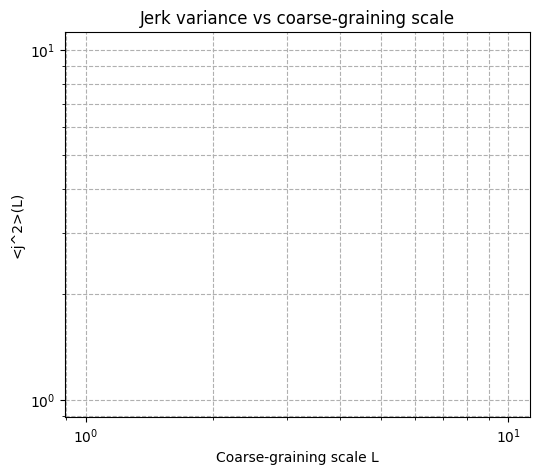

In [78]:
# ============================================================
# Jerk variance scaling: <j^2>(L) vs coarse-graining scale L
# ============================================================

df = df1_p.copy()
df.head()

# 1. 选取一个时间切片 t0（中间时刻，噪声较小）
unique_t = np.sort(df['t'].unique())
t0 = unique_t[len(unique_t)//2]
df_t = df[df['t'] == t0].reset_index(drop=True)
print("Using time slice t =", t0, "  N_particles =", len(df_t))

# 2. 取出位置与 jerk 分量
# 如果你的列名不同，在这里修改
x = df_t['x'].values
y = df_t['y'].values
z = df_t['z'].values

jx = df_t['vx'].values
jy = df_t['vy'].values
jz = df_t['vz'].values

pos = np.vstack([x, y, z]).T
jerk = np.vstack([jx, jy, jz]).T

# 3. 定义一个函数：给定格子尺度 L，计算 coarse-grained <j^2>(L)
def compute_j2_coarse(pos, jerk, L):
    """
    在给定格子尺度 L 下：
      - 将空间切成大小为 L 的立方格
      - 在每个格子内对 jerk 向量取平均
      - 计算 |j_L|^2，并在所有非空格子上取平均
    返回：<j^2>(L)
    """
    x, y, z = pos[:,0], pos[:,1], pos[:,2]
    
    # 确定网格边界（略微扩展一点点）
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    z_min, z_max = z.min(), z.max()
    
    x_edges = np.arange(x_min, x_max + L, L)
    y_edges = np.arange(y_min, y_max + L, L)
    z_edges = np.arange(z_min, z_max + L, L)
    
    # 用 histogramdd 分别对 jx, jy, jz 做“加权累加”，并统计粒子数
    # counts: 每个格子里粒子数
    counts, _ = np.histogramdd(pos, bins=(x_edges, y_edges, z_edges))
    
    sum_jx, _ = np.histogramdd(pos, bins=(x_edges, y_edges, z_edges), weights=jx)
    sum_jy, _ = np.histogramdd(pos, bins=(x_edges, y_edges, z_edges), weights=jy)
    sum_jz, _ = np.histogramdd(pos, bins=(x_edges, y_edges, z_edges), weights=jz)
    
    # 避免除零
    mask = counts > 0
    jx_mean = np.zeros_like(sum_jx)
    jy_mean = np.zeros_like(sum_jy)
    jz_mean = np.zeros_like(sum_jz)
    
    jx_mean[mask] = sum_jx[mask] / counts[mask]
    jy_mean[mask] = sum_jy[mask] / counts[mask]
    jz_mean[mask] = sum_jz[mask] / counts[mask]
    
    # 每个非空格子的 |j_L|^2
    j2_cell = jx_mean**2 + jy_mean**2 + jz_mean**2
    
    # 只在非空格子上取平均
    if np.sum(mask) == 0:
        return np.nan
    j2_avg = j2_cell[mask].mean()
    return j2_avg

# 4. 扫描不同 coarse-graining 尺度 L
#   这里的单位假设与你的坐标一致（例如 mm）
L_list = [20, 40, 80, 160]  # 你可以根据 swarm 尺寸调整
j2_list = []

for L in L_list:
    j2_L = compute_j2_coarse(pos, jerk, L)
    j2_list.append(j2_L)
    print(f"L = {L:5.1f} -> <j^2>(L) = {j2_L:.4e}")

# 5. 画出 <j^2>(L) vs L （推荐 log-log 图）
plt.figure(figsize=(6,5))
plt.loglog(L_list, j2_list, "o-", lw=2)
plt.xlabel("Coarse-graining scale L")
plt.ylabel(r"<j^2>(L)")
plt.title("Jerk variance vs coarse-graining scale")
plt.grid(True, which='both', ls='--')
plt.show()


##### try with 2D $j^2$ field
nan as well

In [ ]:
# ============================================================
# 2D jerk variance scaling (project to xy plane)
# ============================================================

df = df1_p.copy()

# Pick a time slice t0
unique_t = np.sort(df['t'].unique())
t0 = unique_t[len(unique_t)//2]
df_t = df[df['t'] == t0].reset_index(drop=True)

print("Using time slice t =", t0, "N =", len(df_t))

# Extract 2D coords
x = df_t['x'].values
y = df_t['y'].values

jx = df_t['vx'].values
jy = df_t['vy'].values
jz = df_t['vz'].values

pos2 = np.vstack([x, y]).T
jmag = np.sqrt(jx**2 + jy**2 + jz**2)

def compute_j2_2D(pos2, jmag, L):
    x, y = pos2[:,0], pos2[:,1]
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()

    x_edges = np.arange(x_min, x_max + L, L)
    y_edges = np.arange(y_min, y_max + L, L)

    counts, _, _ = np.histogram2d(x, y, bins=(x_edges, y_edges))
    sums, _, _   = np.histogram2d(x, y, bins=(x_edges, y_edges), weights=jmag)

    mask = counts > 0
    j_mean = np.zeros_like(counts)
    j_mean[mask] = sums[mask] / counts[mask]

    return np.mean(j_mean[mask]**2) if np.any(mask) else np.nan

L_list = [20, 30, 50, 80, 120]
j2_list = []

for L in L_list:
    j2 = compute_j2_2D(pos2, jmag, L)
    j2_list.append(j2)
    print(f"L={L:4.0f} -> <j^2>(L) = {j2}")

plt.figure(figsize=(6,5))
plt.loglog(L_list, j2_list, "o-", lw=2)
plt.xlabel("L (2D coarse-graining scale)")
plt.ylabel(r"<j^2>(L)")
plt.title("2D jerk variance scaling")
plt.grid(True, which="both")
plt.show()


Using time slice t = 55.01 N = 97
L=  20 -> <j^2>(L) = nan
L=  30 -> <j^2>(L) = nan
L=  50 -> <j^2>(L) = nan
L=  80 -> <j^2>(L) = nan
L= 120 -> <j^2>(L) = nan


##### try topology scheme
Nan as well

Using t = 55.01 N = 97
k= 3 → <j^2>(k) = nan
k= 5 → <j^2>(k) = nan
k= 8 → <j^2>(k) = nan
k=12 → <j^2>(k) = nan
k=16 → <j^2>(k) = nan
k=20 → <j^2>(k) = nan
k=25 → <j^2>(k) = nan


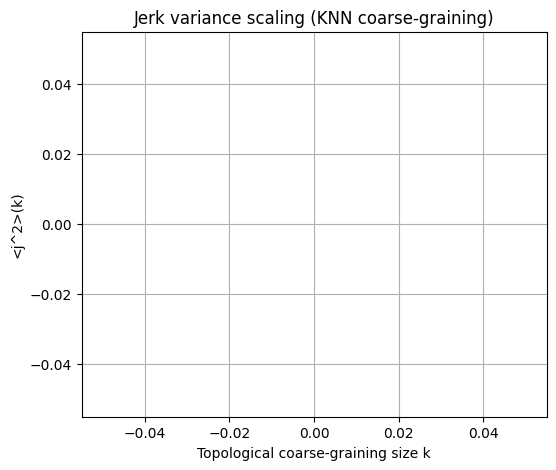

In [ ]:
from sklearn.neighbors import NearestNeighbors

# ===========================================
# KNN-based coarse-graining for jerk scaling
# ===========================================

df = df1_p.copy()

# pick a time
unique_t = np.sort(df['t'].unique())
t0 = unique_t[len(unique_t)//2]
df_t = df[df['t'] == t0].reset_index(drop=True)

print("Using t =", t0, "N =", len(df_t))

# positions and jerk
pos = df_t[['x','y','z']].values
jerk = df_t[['vx','vy','vz']].values
jmag = np.linalg.norm(jerk, axis=1)

# K list
k_list = [3, 5, 8, 12, 16, 20, 25]

j2_list = []

for k in k_list:
    nbrs = NearestNeighbors(n_neighbors=k).fit(pos)
    distances, indices = nbrs.kneighbors(pos)
    
    # j_k(i) = average jerk of k nearest neighbors
    j_k = jerk[indices].mean(axis=1)
    j2 = np.mean(np.linalg.norm(j_k, axis=1)**2)
    
    j2_list.append(j2)
    print(f"k={k:2d} → <j^2>(k) = {j2:.4e}")

# plot
plt.figure(figsize=(6,5))
plt.plot(k_list, j2_list, 'o-', lw=2)
plt.xlabel("Topological coarse-graining size k")
plt.ylabel(r"<j^2>(k)")
plt.title("Jerk variance scaling (KNN coarse-graining)")
plt.grid(True)
plt.show()


##### revisiting the dataset
dataset is correct(jerk correctly listed)

In [81]:
df = df1_p.copy()
unique_t = np.sort(df['t'].unique())
t0 = unique_t[len(unique_t)//2]
df_t = df[df['t'] == t0].reset_index(drop=True)

print("Using t =", t0, "N =", len(df_t))
print(df_t[['jx','jy','jz']].head())

print("\nNaN ratio per component:")
for col in ['jx','jy','jz']:
    nan_ratio = df_t[col].isna().mean()
    print(f"{col}: {nan_ratio:.3f}")


Using t = 55.01 N = 97
         jx       jy        jz
0  8.501833  0.90736 -1.372056
1  7.767913  0.19636 -1.138056
2  8.523913  0.08636 -0.753056
3  8.231913 -0.04364 -0.702056
4  8.627913 -0.14364 -0.987056

NaN ratio per component:
jx: 0.021
jy: 0.021
jz: 0.021


##### distance so large

In [82]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

pos = df_t[['x','y','z']].values

nbrs = NearestNeighbors(n_neighbors=5).fit(pos)
distances, indices = nbrs.kneighbors(pos)

print("Mean distance to 5 nearest neighbors:", distances[:,1:].mean())
print("Min distance:", distances[:,1:].min())
print("Max distance:", distances[:,1:].max())


Mean distance to 5 nearest neighbors: 90.32102783896663
Min distance: 17.292117539503366
Max distance: 292.81656583028223


#### A nice try
pick time window of ±0.5s around middle time

Time window: 54.51 ~ 55.51   N = 9859
After removing NaN jerk, N = 9736
k=5: <j^2>=1.8898e+00
k=10: <j^2>=5.2806e-01
k=15: <j^2>=2.9277e-01
k=20: <j^2>=2.0131e-01
k=25: <j^2>=1.4704e-01
k=30: <j^2>=1.1398e-01
k=35: <j^2>=9.2291e-02
k=40: <j^2>=7.5941e-02
k=45: <j^2>=6.5550e-02
k=50: <j^2>=5.7605e-02
k=55: <j^2>=5.1191e-02
k=60: <j^2>=4.6079e-02
k=65: <j^2>=4.2690e-02
k=70: <j^2>=3.8679e-02
k=75: <j^2>=3.5035e-02
k=80: <j^2>=3.1883e-02
k=85: <j^2>=2.9200e-02
k=90: <j^2>=2.6756e-02
k=95: <j^2>=2.4818e-02
k=100: <j^2>=2.3083e-02
k=105: <j^2>=2.1925e-02
k=110: <j^2>=2.0383e-02
k=115: <j^2>=1.9239e-02
k=120: <j^2>=1.8422e-02
k=125: <j^2>=1.7368e-02
k=130: <j^2>=1.6810e-02
k=135: <j^2>=1.6033e-02
k=140: <j^2>=1.5228e-02
k=145: <j^2>=1.4845e-02
k=150: <j^2>=1.3949e-02
k=155: <j^2>=1.3345e-02
k=160: <j^2>=1.2880e-02
k=165: <j^2>=1.2492e-02
k=170: <j^2>=1.2094e-02
k=175: <j^2>=1.1898e-02
k=180: <j^2>=1.1404e-02
k=185: <j^2>=1.0849e-02
k=190: <j^2>=1.0615e-02
k=195: <j^2>=1.0298e-02
k=200: <j^2>

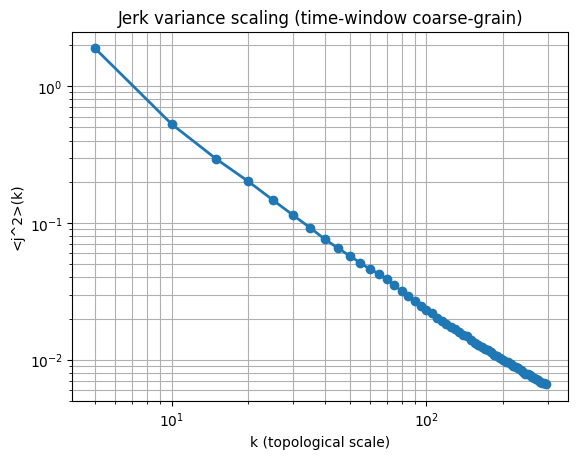

In [94]:
from sklearn.neighbors import NearestNeighbors

df = df1_p.copy()

# pick time window of ±0.5s around middle time
unique_t = np.sort(df['t'].unique())
t0 = unique_t[len(unique_t)//2]
dt = 0.5   # seconds

df_win = df[(df['t'] >= t0 - dt) & (df['t'] <= t0 + dt)].reset_index(drop=True)
print("Time window:", t0-dt, "~", t0+dt, "  N =", len(df_win))

pos = df_win[['x','y','z']].values
jx = df_win['jx'].values
jy = df_win['jy'].values
jz = df_win['jz'].values
jerk = np.vstack([jx, jy, jz]).T

# remove any remaining NaN rows
mask = ~np.isnan(jerk).any(axis=1)
pos = pos[mask]
jerk = jerk[mask]

print("After removing NaN jerk, N =", len(pos))

# KNN scaling
k_list = []
for i in range (5,300,5):
    k_list.append(i)
j2_list = []

for k in k_list:
    nbrs = NearestNeighbors(n_neighbors=k).fit(pos)
    distances, idx = nbrs.kneighbors(pos)
    
    j_k = jerk[idx].mean(axis=1)
    j2 = np.mean(np.linalg.norm(j_k, axis=1)**2)
    
    j2_list.append(j2)
    print(f"k={k}: <j^2>={j2:.4e}")

plt.loglog(k_list, j2_list, "o-", lw=2)
plt.xlabel("k (topological scale)")
plt.ylabel("<j^2>(k)")
plt.title("Jerk variance scaling (time-window coarse-grain)")
plt.grid(True, which="both")
plt.show()


In [110]:
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import curve_fit

# =============================
# 通用的 power-law 拟合函数
# =============================
def _power_law(x, C, alpha):
    return C * x**(-alpha)

### 拓扑结构下的<v^2><a^2><j^2>

In [129]:
def analyze_knn_scaling(
    df_win,
    k_list,
    pos_cols=('x','y','z'),
    v_cols=('vx','vy','vz'),
    a_cols=('ax','ay','az'),
    j_cols=('jx','jy','jz')
):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.neighbors import NearestNeighbors
    from scipy.optimize import curve_fit

    def _power_law(x, C, alpha):
        return C * x**(-alpha)

    df = df_win.copy()
    
    # -------- v/a/j 的基础数据处理 --------
    # velocity
    pos_v = df[list(pos_cols)].values
    vel_vec = df[list(v_cols)].values
    mask_v = ~np.isnan(vel_vec).any(axis=1)
    pos_v = pos_v[mask_v]
    vel_vec = vel_vec[mask_v]
    
    # acceleration
    pos_a = df[list(pos_cols)].values
    acc_vec = df[list(a_cols)].values
    mask_a = ~np.isnan(acc_vec).any(axis=1)
    pos_a = pos_a[mask_a]
    acc_vec = acc_vec[mask_a]
    
    # jerk
    pos_j = df[list(pos_cols)].values
    jerk_vec = df[list(j_cols)].values
    mask_j = ~np.isnan(jerk_vec).any(axis=1)
    pos_j = pos_j[mask_j]
    jerk_vec = jerk_vec[mask_j]
    
    print(f"[KNN] N_v={len(pos_v)}, N_a={len(pos_a)}, N_j={len(pos_j)}")
    
    # -------- 通用 KNN variance 计算 --------
    def _var_knn(pos, vec, k_int):
        nbrs = NearestNeighbors(n_neighbors=int(k_int)).fit(pos)
        _, idx = nbrs.kneighbors(pos)
        vec_k = vec[idx].mean(axis=1)
        return np.mean(np.linalg.norm(vec_k, axis=1)**2)

    # k 必须是 int
    k_arr = np.array(k_list, dtype=int)

    # v scaling
    v2_list = [ _var_knn(pos_v, vel_vec, int(k)) for k in k_arr ]
    popt_v, _ = curve_fit(_power_law, k_arr.astype(float), np.array(v2_list))
    alpha_v = popt_v[1]
    
    # a scaling
    a2_list = [ _var_knn(pos_a, acc_vec, int(k)) for k in k_arr ]
    popt_a, _ = curve_fit(_power_law, k_arr.astype(float), np.array(a2_list))
    alpha_a = popt_a[1]
    
    # j scaling
    j2_list = [ _var_knn(pos_j, jerk_vec, int(k)) for k in k_arr ]
    popt_j, _ = curve_fit(_power_law, k_arr.astype(float), np.array(j2_list))
    alpha_j = popt_j[1]
    
    print(f"[KNN] alpha_v(k) = {alpha_v}")
    print(f"[KNN] alpha_a(k) = {alpha_a}")
    print(f"[KNN] alpha_j(k) = {alpha_j}")
    
    # -------- 画图 --------
    # v
    plt.figure(figsize=(6,5))
    plt.loglog(k_arr, v2_list, 'o', label='v^2 data')
    plt.loglog(k_arr, _power_law(k_arr, *popt_v), '-', label=f'fit α={alpha_v:.2f}')
    plt.xlabel('k (topological scale)')
    plt.ylabel('<v^2>(k)')
    plt.grid(True, which='both')
    plt.legend()
    plt.show()

    # a
    plt.figure(figsize=(6,5))
    plt.loglog(k_arr, a2_list, 'o', label='a^2 data')
    plt.loglog(k_arr, _power_law(k_arr, *popt_a), '-', label=f'fit α={alpha_a:.2f}')
    plt.xlabel('k (topological scale)')
    plt.ylabel('<a^2>(k)')
    plt.grid(True, which='both')
    plt.legend()
    plt.show()

    # j
    plt.figure(figsize=(6,5))
    plt.loglog(k_arr, j2_list, 'o', label='j^2 data')
    plt.loglog(k_arr, _power_law(k_arr, *popt_j), '-', label=f'fit α={alpha_j:.2f}')
    plt.xlabel('k (topological scale)')
    plt.ylabel('<j^2>(k)')
    plt.grid(True, which='both')
    plt.legend()
    plt.show()
    
    return {'v': alpha_v, 'a': alpha_a, 'j': alpha_j}


In [130]:
dt = 0.5
df_win = df[(df['t'] >= t0-dt) & (df['t'] <= t0+dt)]

In [134]:
k_list = []
for i in range (5,100,5):
    k_list.append(i)

[KNN] N_v=9816, N_a=9775, N_j=9736
[KNN] alpha_v(k) = 0.48474540676513017
[KNN] alpha_a(k) = 1.6108689908750322
[KNN] alpha_j(k) = 1.669984013727054


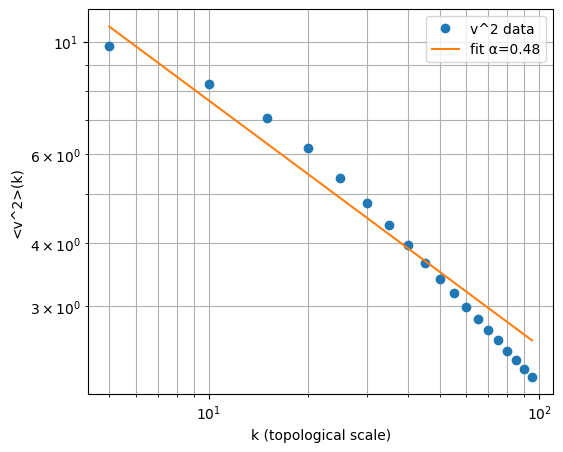

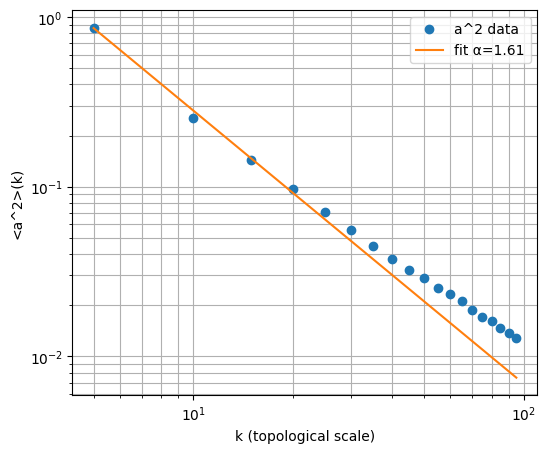

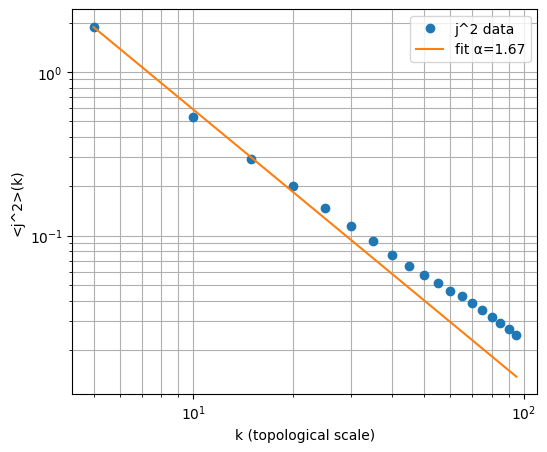

In [135]:
alpha_knn = analyze_knn_scaling(df_win, k_list)

### 空间尺度结构下的<v^2><a^2><j^2>

In [115]:
# =============================
# 2. Metric（L 网格）scaling
# =============================
def analyze_metric_scaling(
    df_win,
    L_list,
    pos_cols=('x','y'),    # 这里用 xy 投影
    v_cols=('vx','vy','vz'),
    a_cols=('ax','ay','az'),
    j_cols=('jx','jy','jz')
):
    """
    对给定时间窗口 df_win，在 metric 尺度 L 下分析
    <v^2>(L), <a^2>(L), <j^2>(L) 的标度，并拟合 alpha。
    
    参数:
      - df_win: 选好的时间窗口数据 DataFrame
      - L_list: 物理尺度列表，如 [20,40,60,...]
      - pos_cols: 位置列名（默认为 (x,y)）
      - v_cols, a_cols, j_cols: 对应 v/a/j 的列名
    
    输出:
      - 打印每个变量的 alpha
      - 画三幅 log–log 图
      - 返回一个 dict: {'v': alpha_v, 'a': alpha_a, 'j': alpha_j}
    """
    df = df_win.copy()
    L_arr = np.array(L_list, dtype=float)
    
    # 投影坐标（默认 x,y）
    pos_xy = df[list(pos_cols)].values
    
    # 三种量的模长
    vel_vec = df[list(v_cols)].values
    acc_vec = df[list(a_cols)].values
    jerk_vec = df[list(j_cols)].values
    
    vmag = np.linalg.norm(vel_vec, axis=1)
    amag = np.linalg.norm(acc_vec, axis=1)
    jmag = np.linalg.norm(jerk_vec, axis=1)
    
    # 各自去掉 NaN
    def _clean(pos, mag):
        mask = ~np.isnan(mag)
        return pos[mask], mag[mask]
    
    pos_v, vmag = _clean(pos_xy, vmag)
    pos_a, amag = _clean(pos_xy, amag)
    pos_j, jmag = _clean(pos_xy, jmag)
    
    print(f"[Metric] N_v={len(pos_v)}, N_a={len(pos_a)}, N_j={len(pos_j)}")
    
    # metric coarse-grain 工具
    def _var_L(pos, mag, L):
        x = pos[:,0]
        y = pos[:,1]
        x_edges = np.arange(x.min(), x.max()+L, L)
        y_edges = np.arange(y.min(), y.max()+L, L)
        
        counts, _, _ = np.histogram2d(x, y, bins=(x_edges, y_edges))
        sums, _, _   = np.histogram2d(x, y, bins=(x_edges, y_edges), weights=mag)
        
        mask = counts > 0
        if not np.any(mask):
            return np.nan
        
        mean_mag = sums[mask] / counts[mask]
        return np.mean(mean_mag**2)
    
    # 计算三组 <·^2>(L)
    v2L_list = [ _var_L(pos_v, vmag, L) for L in L_arr ]
    a2L_list = [ _var_L(pos_a, amag, L) for L in L_arr ]
    j2L_list = [ _var_L(pos_j, jmag, L) for L in L_arr ]
    
    # power-law 拟合
    popt_v, _ = curve_fit(_power_law, L_arr, np.array(v2L_list), p0=[v2L_list[0], 0.1])
    alpha_v = popt_v[1]
    
    popt_a, _ = curve_fit(_power_law, L_arr, np.array(a2L_list), p0=[a2L_list[0], 0.1])
    alpha_a = popt_a[1]
    
    popt_j, _ = curve_fit(_power_law, L_arr, np.array(j2L_list), p0=[j2L_list[0], 0.1])
    alpha_j = popt_j[1]
    
    print(f"[Metric] alpha_v(L) = {alpha_v}")
    print(f"[Metric] alpha_a(L) = {alpha_a}")
    print(f"[Metric] alpha_j(L) = {alpha_j}")
    
    # 画三幅 log–log 图
    plt.figure(figsize=(6,5))
    plt.loglog(L_arr, v2L_list, 'o', label='v^2 data')
    plt.loglog(L_arr, _power_law(L_arr, *popt_v), '-', label=f'fit α={alpha_v:.3f}')
    plt.xlabel('L (metric scale)')
    plt.ylabel('<v^2>(L)')
    plt.title('Velocity variance scaling (Metric)')
    plt.grid(True, which='both')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(6,5))
    plt.loglog(L_arr, a2L_list, 'o', label='a^2 data')
    plt.loglog(L_arr, _power_law(L_arr, *popt_a), '-', label=f'fit α={alpha_a:.3f}')
    plt.xlabel('L (metric scale)')
    plt.ylabel('<a^2>(L)')
    plt.title('Acceleration variance scaling (Metric)')
    plt.grid(True, which='both')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(6,5))
    plt.loglog(L_arr, j2L_list, 'o', label='j^2 data')
    plt.loglog(L_arr, _power_law(L_arr, *popt_j), '-', label=f'fit α={alpha_j:.3f}')
    plt.xlabel('L (metric scale)')
    plt.ylabel('<j^2>(L)')
    plt.title('Jerk variance scaling (Metric)')
    plt.grid(True, which='both')
    plt.legend()
    plt.show()
    
    return {'v': alpha_v, 'a': alpha_a, 'j': alpha_j}


[Metric] N_v=9816, N_a=9775, N_j=9736
[Metric] alpha_v(L) = 0.05618831037587639
[Metric] alpha_a(L) = 0.027424629105975637
[Metric] alpha_j(L) = 0.021601134335611186


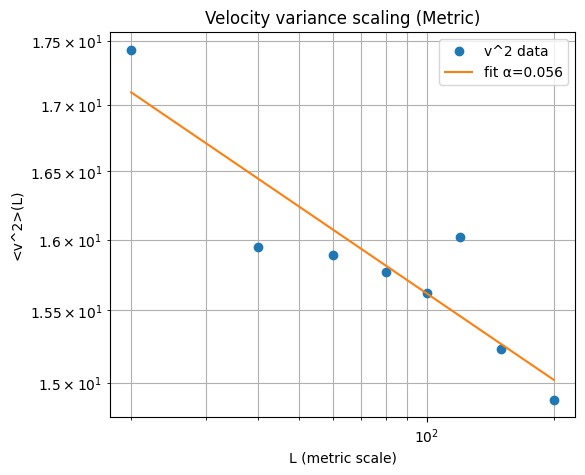

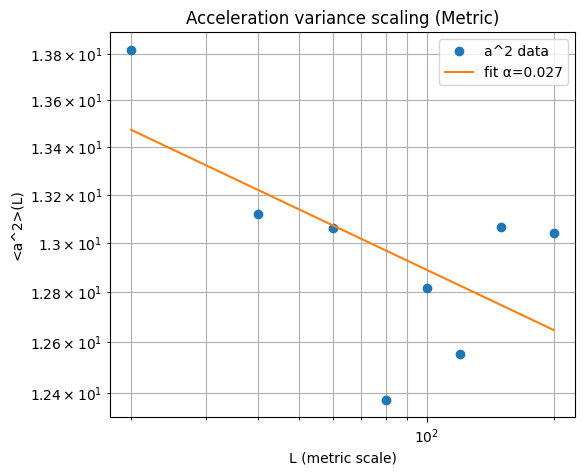

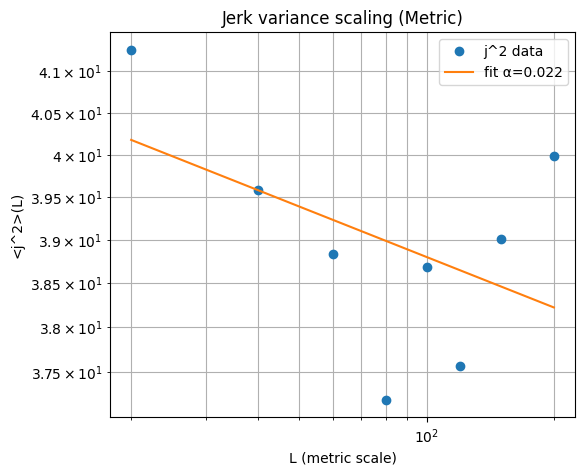

In [121]:
alpha_metric = analyze_metric_scaling(df_win, [20,40,60,80,100,120,150,200])

5.1节结论：
在 topological coarse-graining（按邻居数）下，加速度和 jerk 的方差都表现出幂律缩放，指数约为 
α≈1.6∼1.7，而在 metric coarse-graining（按物理距离 L）下，这些量几乎不缩放。
这表明 midges 的惯性响应主要由拓扑邻居结构控制，而非简单的 metric 长度尺度；加速度和 jerk 作为场变量在同一 universality class 中，但在具体建模时可优先采用加速度场，并将 jerk 视为其时间变化的高阶修

这个部分在Overleaf：field 文件的5.1部分里了

### 5.3 real-space RG

粗粒化 ρ,v,a,j
并构建：
\begin{equation}
\beta_j = k\partial_k j(k)
\tag{5.3}
\end{equation}

判断 fixed point：

jerk fixed point?

noise-dominated fixed point?

geometry-dominated fixed point?

### 5.4 fitting PDE

### 5.5 Universality 分类

结论：

不属于 Toner–Tu

不属于 alignment class

属于新的 jerk-driven active matter universality class

## Step 6. 结合 Reynolds（2023–2024）的“jerk & shear hardening”模型

对昆虫群分析：

mean jerk vs location

acceleration variance vs radius

Reynolds number tuning

是否存在 shear hardening / softening

这部分是你能在**“昆虫群 vs 蚊群 vs 鸟群”**三者中提出的新 universality class。

## Step 7. SPP / agent-based 模拟验证

根据你推断的参数构建模拟：

self-propelled particles

metric / topological 规则

inclusion of jitter

inclusion of room boundary

simulate velocity field + sound modes

验证实验图的 reproduction：

C(r)

S(q)

sound modes

# 2. 研究方向（Research Directions）

这些方向均符合“可发 PRL / PNAS / JRSI”的水平。

## 方向 A：昆虫群的 Toner–Tu 场论验证（首次）

计算 scaling exponent（z, ζ, x）

是否一致？

是否出现 TT 声模？

目前无人做过，属于“重大空白 → 高价值”。

## 方向 B：昆虫群中的 Reynolds-type jerk-driven dynamics

jerk noise vs position

shear hardening?

Reynolds number tuning?

comparative study: midge vs mosquito vs bird

## 方向 C：昆虫群的最大熵微观规则推断

metric vs topological

J vs nc vs density
+
anisotropy

boundary influence

## 方向 D：昆虫群的相变与有限尺度效应（RG 视角）

如何从 quasi-ordered → disordered 转变？

finite-size scaling

confinement-induced universality class

## 方向 E：构建统一的“昆虫群场论 + 最大熵 + RG”框架

作为博士/项目的旗舰方向：

数据驱动 + 场论推导 + RG + 模型反演 + 模拟验证
形成“真实昆虫群的完整场论模型”。